In [ ]:
!dir

In [ ]:
from scipy.io import loadmat

mat_data = loadmat("./clean_project/Market-1501-v15.09.15/gt_query/0001_c1s1_001051_00_good.mat")
print(mat_data.keys())  # 查看文件中的键
features = mat_data.get('features', None)  # 假设特征向量存储在 'features' 键中


In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd

class Market1501SimpleDebugger:
    def __init__(self, radio_processor, dataset_path, num_samples=10):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        self.num_samples = num_samples
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        self.gt_path = self.dataset_path / "gt_query"
        
        # 特徵緩存
        self.feature_cache = {}

    def _get_person_id(self, img_name):
        """獲取圖像的人物ID"""
        return img_name[:4]

    def extract_features(self, image_path):
        """提取圖像特徵"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]

    def debug_evaluation(self):
        """執行簡單的調試評估"""
        # 選擇10個查詢樣本
        query_files = list(self.query_path.glob('*.jpg'))
        selected_queries = np.random.choice(query_files, self.num_samples, replace=False)
        
        overall_results = []
        correct_count = 0
        
        print(f"開始評估 {self.num_samples} 個查詢樣本...")
        
        for query_path in tqdm(selected_queries, desc="處理查詢樣本"):
            query_name = query_path.name
            query_id = self._get_person_id(query_name)
            query_feature = self.extract_features(query_path)
            
            # 與gallery中的所有圖像比對
            similarities = []
            gallery_files = list(self.gallery_path.glob('*.jpg'))
            
            for gallery_path in gallery_files:
                gallery_name = gallery_path.name
                gallery_id = self._get_person_id(gallery_name)
                gallery_feature = self.extract_features(gallery_path)
                
                similarity = float(np.dot(query_feature.flatten(), gallery_feature.flatten()))
                similarities.append({
                    'gallery_name': gallery_name,
                    'similarity': similarity,
                    'is_match': gallery_id == query_id
                })
            
            # 根據相似度排序並取前10個結果
            top_matches = sorted(similarities, key=lambda x: x['similarity'], reverse=True)[:]
            
            # 檢查第一個匹配是否正確
            if top_matches[0]['is_match']:
                correct_count += 1
            
            # 顯示當前查詢的結果
            print(f"\n查詢圖像: {query_name} (ID: {query_id})")
            results_df = pd.DataFrame(top_matches)
            print(results_df)
            
            overall_results.append({
                'query_name': query_name,
                'query_id': query_id,
                'top1_correct': top_matches[0]['is_match']
            })
        
        # 計算並顯示最終準確率
        accuracy = correct_count / self.num_samples
        print(f"\n最終準確率: {accuracy:.2%} ({correct_count}/{self.num_samples})")
        
        return pd.DataFrame(overall_results)

# 使用示例
if __name__ == "__main__":
    from radio_feature_processor import RADIOFeatureProcessor
    
    # 初始化
    radio_processor = RADIOFeatureProcessor(model_version="radio_v2.5-b")
    debugger = Market1501SimpleDebugger(radio_processor, "./Market-1501-v15.09.15")
    
    # 運行調試評估
    results = debugger.debug_evaluation()

In [1]:
# -*- coding: utf-8 -*-
# Jupyter Notebook 環境內請確保使用 UTF-8 編碼

import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.io import loadmat

# 確保圖表在 Notebook 內顯示
%matplotlib inline

##############################################
# 假設 radio_feature_processor.py 已存在並包含:
# class RADIOFeatureProcessor:
#     def __init__(self, model_version="radio_v2.5-b"):
#         # 進行模型初始化
#         pass
#
#     def extract_features(self, image_path):
#         # 回傳 feature numpy array
#         # 範例中僅示意，實際請按照自身模型實作
#         feature_dim = 512
#         # 假設回傳隨機向量作為 features
#         return np.random.rand(feature_dim)
##############################################

from radio_feature_processor import RADIOFeatureProcessor

class Market1501SimpleDebugger:
    def __init__(self, radio_processor, dataset_path, num_samples=10):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        self.num_samples = num_samples
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        self.gt_path = self.dataset_path / "gt_query"
        
        # 特徵緩存
        self.feature_cache = {}

    def _get_person_id(self, img_name):
        """根據影像檔名，擷取人物 ID（前 4 碼）"""
        return img_name[:4]

    def extract_features(self, image_path):
        """提取圖像特徵並做快取"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]

    def debug_evaluation(self):
        """執行簡單的調試評估，回傳包含各 query 之結果細節的 DataFrame。"""
        
        # 隨機挑選 num_samples 張查詢圖像
        query_files = list(self.query_path.glob('*.jpg'))
        selected_queries = np.random.choice(query_files, self.num_samples, replace=False)
        
        overall_results = []
        correct_count = 0
        
        print(f"開始評估 {self.num_samples} 個查詢樣本...")
        
        # 走訪每個查詢影像
        for query_path in tqdm(selected_queries, desc="處理查詢樣本"):
            query_name = query_path.name
            query_id = self._get_person_id(query_name)
            
            # 提取 query 特徵
            query_feature = self.extract_features(query_path)
            
            # 與整個 gallery 做比對
            similarities = []
            gallery_files = list(self.gallery_path.glob('*.jpg'))
            
            for gallery_path in gallery_files:
                gallery_name = gallery_path.name
                gallery_id = self._get_person_id(gallery_name)
                gallery_feature = self.extract_features(gallery_path)
                
                # 這裡以向量內積作為相似度，越大越相似
                similarity = float(np.dot(query_feature.flatten(), gallery_feature.flatten()))
                similarities.append({
                    'gallery_name': gallery_name,
                    'similarity': similarity,
                    'is_match': gallery_id == query_id
                })
            
            # 根據相似度排序
            top_matches = sorted(similarities, key=lambda x: x['similarity'], reverse=True)
            
            # 檢查 Top1 是否正確
            if top_matches[0]['is_match']:
                correct_count += 1
            
            # 也可以在此顯示每個 query 的所有 ranking 結果，如需要可以放入 DataFrame
            # 這裡只先記錄 Top1 結果
            overall_results.append({
                'query_name': query_name,
                'query_id': query_id,
                'top1_correct': top_matches[0]['is_match']
            })
        
        # 計算最終 Top1 準確率
        accuracy = correct_count / self.num_samples
        
        print(f"\n最終 Top1 準確率: {accuracy:.2%} ({correct_count}/{self.num_samples})")
        
        # 回傳測試細節
        return pd.DataFrame(overall_results), accuracy


def run_experiment(model_version, dataset_path, num_samples=100):
    """
    執行一次實驗：
    1. 根據指定的 model_version 初始化 RADIOFeatureProcessor。
    2. 使用 Market1501SimpleDebugger 進行 num_samples 次測試。
    3. 回傳平均單張 query 的特徵擷取時間、該次實驗的 Top1 Accuracy。
    """
    # 初始化模型
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    debugger = Market1501SimpleDebugger(radio_processor, dataset_path, num_samples=num_samples)
    
    # 計時開始
    start_time = time.time()
    # 執行測試
    results_df, accuracy = debugger.debug_evaluation()
    end_time = time.time()
    
    total_time = end_time - start_time
    # 平均每張 query 所花費的時間
    avg_time_per_query = total_time / num_samples
    
    return avg_time_per_query, accuracy, results_df


if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"

    # 要測試的四種模型
    # model_versions = ["radio_v2.5-b", "radio_v2.5-l", "radio_v2.5-h", "e-radio_v2"]
    
    model_versions = ["e-radio_v2"]
    # 儲存實驗結果
    experiment_results = []

    # 執行每種模型的測試
    for mv in model_versions:
        print("="*50)
        print(f"現在測試模型：{mv}")
        avg_time, acc, df_details = run_experiment(mv, dataset_path, num_samples=100)
        experiment_results.append({
            'model_version': mv,
            'avg_extraction_time': avg_time,
            'top1_accuracy': acc
        })
    
    # 將實驗結果整理成 DataFrame
    results_df = pd.DataFrame(experiment_results)
    print("\n=== 各模型實驗結果總覽 ===")
    print(results_df)

    # 視覺化：繪製「平均特徵擷取時間」與「Top1 準確率」的長條圖
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(data=results_df, x='model_version', y='avg_extraction_time', ax=axes[0])
    axes[0].set_title("平均特徵擷取時間 (秒)")
    axes[0].set_xlabel("模型版本")
    axes[0].set_ylabel("時間 (秒)")
    # 加上數值標籤
    for i, v in enumerate(results_df['avg_extraction_time']):
        axes[0].text(i, v + 0.001, f"{v:.3f}", ha='center', va='bottom')
    
    sns.barplot(data=results_df, x='model_version', y='top1_accuracy', ax=axes[1])
    axes[1].set_title("Top1 準確率")
    axes[1].set_xlabel("模型版本")
    axes[1].set_ylabel("Accuracy")
    # 加上數值標籤
    for i, v in enumerate(results_df['top1_accuracy']):
        axes[1].text(i, v + 0.001, f"{v:.2%}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GFPGAN model loaded successfully!
現在測試模型：e-radio_v2
Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model output type: <class 'radio.adaptor_base.RadioOutput'>
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 1536])
Initialized FAISS index
開始評估 100 個查詢樣本...


處理查詢樣本:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main


Model hash: 7cf2a235907bcc6d43b9e6b5196efda7
Model output type: <class 'radio.adaptor_base.RadioOutput'>
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 2304])
Created new FAISS index for face with dimension 2304
Created new FAISS index for body with dimension 2304
Loaded 60 cached face features
No cached features found for body
共發現 3368 張查詢影像，即將進行完整測試 ...
提取 gallery 特徵 ...


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

開始對每個 query 進行比對並評估 ...


Evaluating queries:   0%|          | 0/3368 [00:00<?, ?it/s]


=== 評估結果 (Model: radio_v2.5-b) ===
平均特徵擷取時間: 0.2016 秒
平均比對時間: 0.1105 秒
平均查詢處理時間: 0.3184 秒
Top-1 準確率: 75.65%
Top-5 準確率: 85.93%
Top-10 準確率: 88.78%
總特徵擷取時間: 678.9014 秒
總比對時間: 372.3144 秒
總處理時間: 1072.4752 秒
總查詢影像數量: 3368


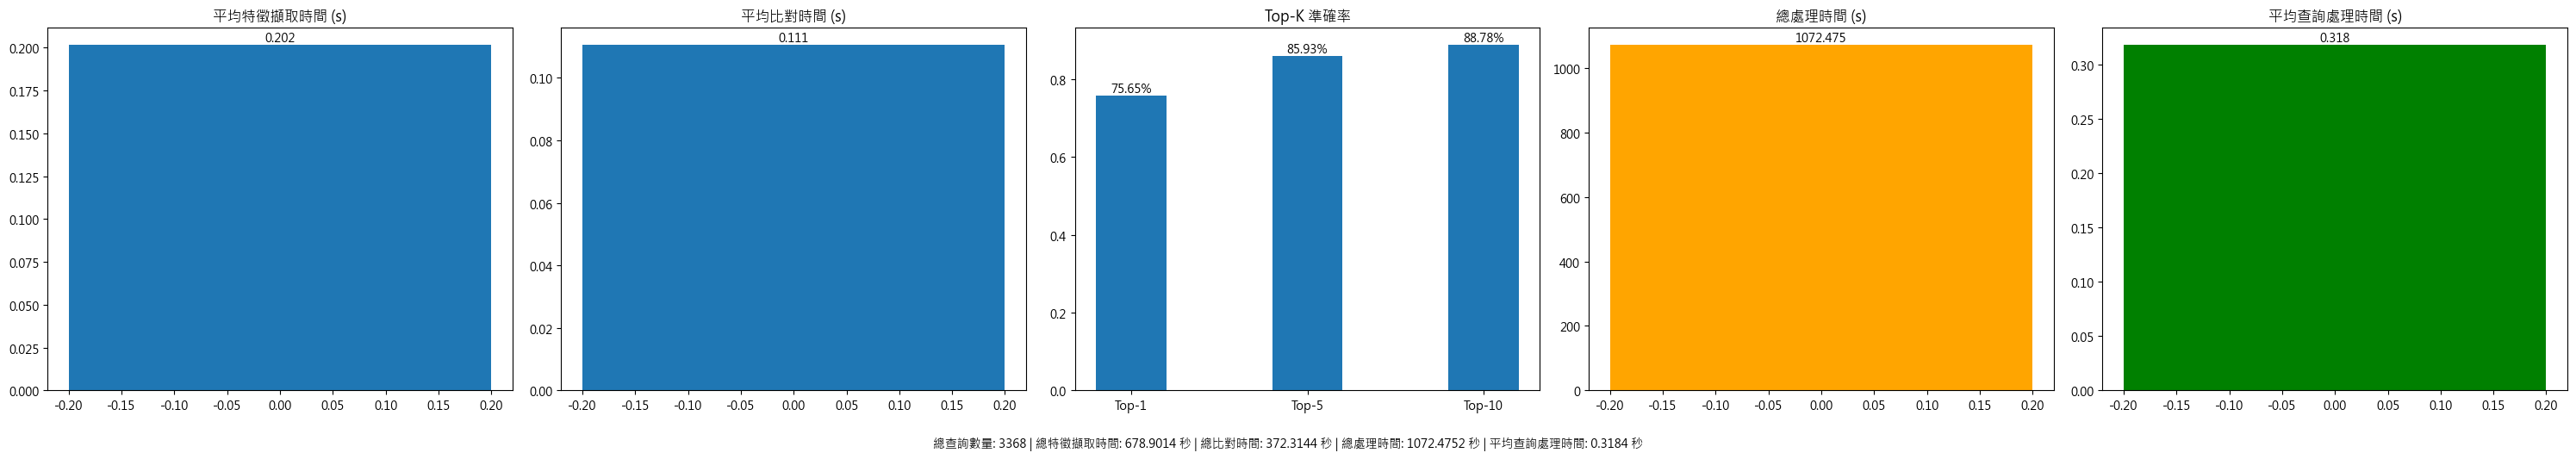

In [6]:
import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from radio_feature_processor import RADIOFeatureProcessor

# 設定字體，確保能同時顯示中文與英文
# 可視環境中安裝的字體名稱自行增減
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [
    "SimHei",            # for Windows/Mac/Linux (若有安裝)
    "Microsoft JhengHei",# for Windows (若有安裝)
    "PingFang TC",       # for Mac (若有安裝)
    "Taipei Sans TC Beta",
    "Arial",             # 英文字體 fallback
]
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

class Market1501FullEvaluator:
    def __init__(self, radio_processor, dataset_path):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        
        # 特徵快取
        self.feature_cache = {}
        
    def _get_person_id(self, img_name):
        """根據影像檔名，擷取人物 ID（可能是前 4 碼），
           也可依實際規則調整。"""
        return img_name.split('_')[0]  # 常見切割方式

    def extract_features(self, image_path):
        """提取圖像特徵，並作快取以避免重覆處理"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]
    
    def evaluate(self):
        """
        執行完整 Market-1501 測試，計算 Top-K 準確率 (1, 5, 10)
        回傳 (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, result_detail_df, 
              total_feat_time, total_match_time, total_deal_time)
        """
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        total_feat_time = 0.0
        total_match_time = 0.0
        top1_correct = 0
        top5_correct = 0
        top10_correct = 0
        results = []
        
        print(f"共發現 {len(query_files)} 張查詢影像，即將進行完整測試 ...")
        
        # 預先提取 gallery 特徵
        print("提取 gallery 特徵 ...")
        for gf in tqdm(gallery_files, desc="Gallery feature extraction"):
            _ = self.extract_features(gf)
        
        # 開始對每個 query 進行評估
        print("開始對每個 query 進行比對並評估 ...")
        t4 = time.time()
        
        for qf in tqdm(query_files, desc="Evaluating queries"):
            q_name = qf.name
            q_id = self._get_person_id(q_name)
            
            # 特徵擷取時間
            t0 = time.time()
            q_feat = self.extract_features(qf)
            t1 = time.time()
            feat_time = t1 - t0
            
            # 比對時間
            t2 = time.time()
            similarities = []
            for gf in gallery_files:
                g_name = gf.name
                g_id = self._get_person_id(g_name)
                g_feat = self.extract_features(gf)
                sim = float(np.dot(q_feat.flatten(), g_feat.flatten()))
                similarities.append((sim, g_id))
            t3 = time.time()
            match_time = t3 - t2
            
            # 排序相似度（由大到小）
            similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
            
            # 計算 Top-K 是否正確
            top1_correct += (similarities[0][1] == q_id)
            top5_correct += any(sim[1] == q_id for sim in similarities[:5])
            top10_correct += any(sim[1] == q_id for sim in similarities[:10])
            
            total_feat_time += feat_time
            total_match_time += match_time
            
            results.append({
                'query_name': q_name,
                'query_id': q_id,
                'top1_correct': similarities[0][1] == q_id,
            })
        
        total_deal_time = time.time() - t4
        
        # 統計
        avg_feat_time = total_feat_time / len(query_files)
        avg_match_time = total_match_time / len(query_files)
        top1_acc = top1_correct / len(query_files)
        top5_acc = top5_correct / len(query_files)
        top10_acc = top10_correct / len(query_files)
        
        detail_df = pd.DataFrame(results)
        
        return (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
                detail_df, total_feat_time, total_match_time, total_deal_time)


def run_and_plot(model_version, dataset_path):
    """
    更新圖表，顯示 Top-1, Top-5, Top-10 準確率、總處理時間與平均處理時間
    並將總時間與資料筆數顯示於圖表下方
    """
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    evaluator = Market1501FullEvaluator(radio_processor, dataset_path)
    
    # 修正：接收所有 9 個返回值
    (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
     detail_df, total_feat_time, total_match_time, total_deal_time) = evaluator.evaluate()
    
    # 計算平均 query 處理時間
    avg_query_time = total_deal_time / len(detail_df)
    
    print(f"\n=== 評估結果 (Model: {model_version}) ===")
    print(f"平均特徵擷取時間: {avg_feat_time:.4f} 秒")
    print(f"平均比對時間: {avg_match_time:.4f} 秒")
    print(f"平均查詢處理時間: {avg_query_time:.4f} 秒")
    print(f"Top-1 準確率: {top1_acc:.2%}")
    print(f"Top-5 準確率: {top5_acc:.2%}")
    print(f"Top-10 準確率: {top10_acc:.2%}")
    print(f"總特徵擷取時間: {total_feat_time:.4f} 秒")
    print(f"總比對時間: {total_match_time:.4f} 秒")
    print(f"總處理時間: {total_deal_time:.4f} 秒")
    print(f"總查詢影像數量: {len(detail_df)}")
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 5))
    
    # 平均特徵擷取時間
    axes[0].bar([0], [avg_feat_time], width=0.4)
    axes[0].set_title("平均特徵擷取時間 (s)")
    axes[0].text(0, avg_feat_time, f"{avg_feat_time:.3f}", ha='center', va='bottom')
    
    # 平均比對時間
    axes[1].bar([0], [avg_match_time], width=0.4)
    axes[1].set_title("平均比對時間 (s)")
    axes[1].text(0, avg_match_time, f"{avg_match_time:.3f}", ha='center', va='bottom')
    
    # Top-K 準確率
    axes[2].bar([0, 1, 2], [top1_acc, top5_acc, top10_acc], width=0.4, tick_label=["Top-1", "Top-5", "Top-10"])
    axes[2].set_title("Top-K 準確率")
    for i, acc in enumerate([top1_acc, top5_acc, top10_acc]):
        axes[2].text(i, acc, f"{acc:.2%}", ha='center', va='bottom')
    
    # 總處理時間
    axes[3].bar([0], [total_deal_time], width=0.4, color='orange')
    axes[3].set_title("總處理時間 (s)")
    axes[3].text(0, total_deal_time, f"{total_deal_time:.3f}", ha='center', va='bottom')
    
    # 平均查詢處理時間
    axes[4].bar([0], [avg_query_time], width=0.4, color='green')
    axes[4].set_title("平均查詢處理時間 (s)")
    axes[4].text(0, avg_query_time, f"{avg_query_time:.3f}", ha='center', va='bottom')
    
    # 加入文字註解
    fig.text(0.5, -0.05, 
             f"總查詢數量: {len(detail_df)} | 總特徵擷取時間: {total_feat_time:.4f} 秒 | " \
             f"總比對時間: {total_match_time:.4f} 秒 | 總處理時間: {total_deal_time:.4f} 秒 | " \
             f"平均查詢處理時間: {avg_query_time:.4f} 秒",
             ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"

    # 指定要評估的模型版本
    model_version = "radio_v2.5-b"
     #"radio_v2.5-g"
     #"e-radio_v2"
     #radio_v2.1
     
    # 執行測試並輸出圖表
    run_and_plot(model_version, dataset_path)

Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
Downloading: "https://huggingface.co/nvidia/RADIO/resolve/main/radio_v2.5-g.pth.tar?download=true" to C:\Users\felix/.cache\torch\hub\checkpoints\radio_v2.5-g.pth.tar
100%|██████████| 2.70G/2.70G [05:55<00:00, 8.17MB/s]


Model hash: b82120a57214eb31153ea01744ec2893
Model output type: <class 'radio.adaptor_base.RadioOutput'>
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 1536])
Created new FAISS index for face with dimension 1536
Created new FAISS index for body with dimension 1536
No cached features found for face
No cached features found for body
共發現 3368 張查詢影像，即將進行完整測試 ...
提取 gallery 特徵 ...


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

開始對每個 query 進行比對並評估 ...


Evaluating queries:   0%|          | 0/3368 [00:00<?, ?it/s]


=== 評估結果 (Model: radio_v2.5-g) ===
平均特徵擷取時間: 1.4097 秒
平均比對時間: 0.0717 秒
平均查詢處理時間: 1.4857 秒
Top-1 準確率: 66.48%
Top-5 準確率: 77.49%
Top-10 準確率: 82.45%
總特徵擷取時間: 4747.9078 秒
總比對時間: 241.3498 秒
總處理時間: 5003.8917 秒
總查詢影像數量: 3368


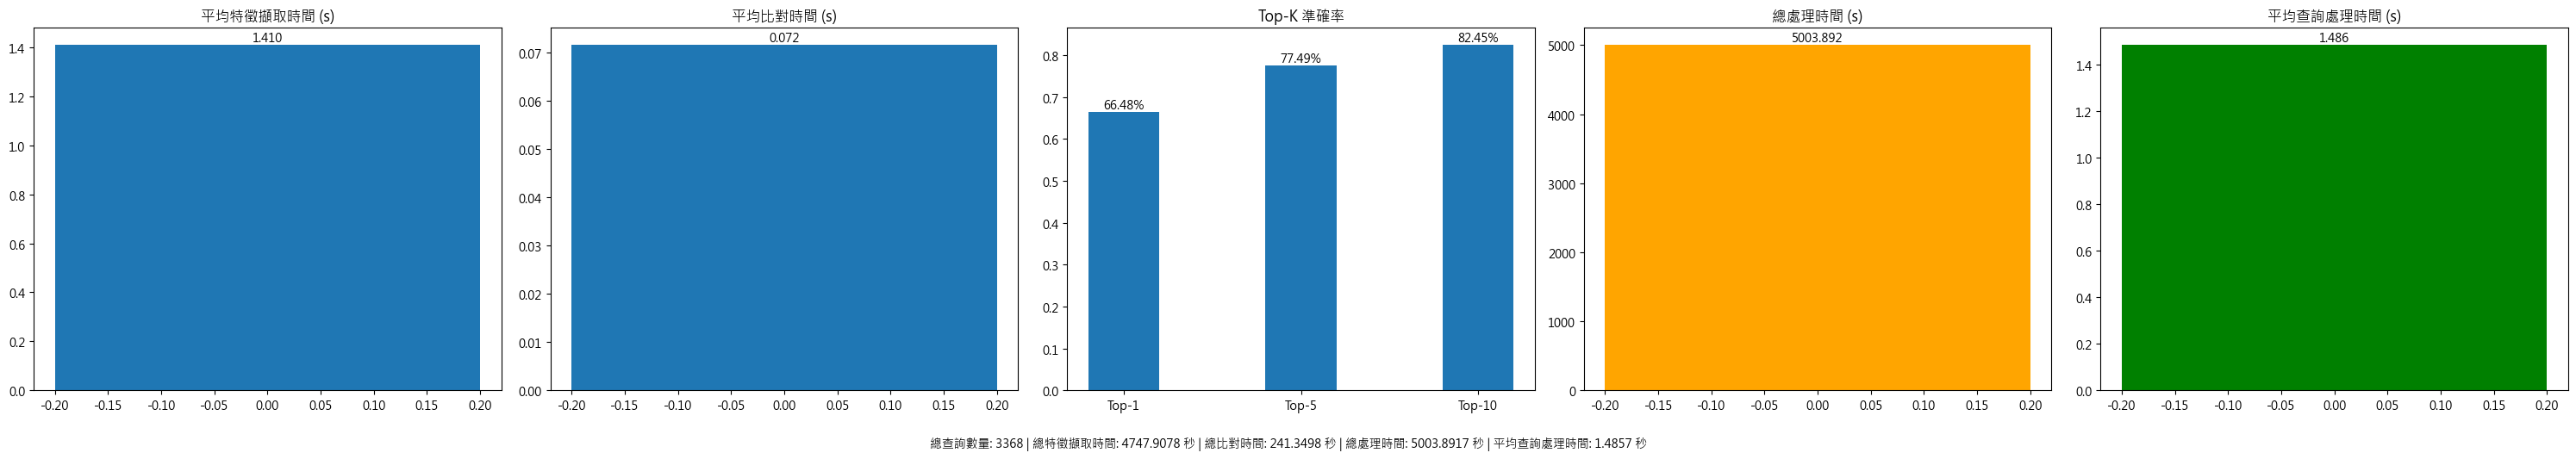

In [4]:
import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from radio_feature_processor import RADIOFeatureProcessor

# 設定字體，確保能同時顯示中文與英文
# 可視環境中安裝的字體名稱自行增減
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [
    "SimHei",            # for Windows/Mac/Linux (若有安裝)
    "Microsoft JhengHei",# for Windows (若有安裝)
    "PingFang TC",       # for Mac (若有安裝)
    "Taipei Sans TC Beta",
    "Arial",             # 英文字體 fallback
]
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

class Market1501FullEvaluator:
    def __init__(self, radio_processor, dataset_path):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        
        # 特徵快取
        self.feature_cache = {}
        
    def _get_person_id(self, img_name):
        """根據影像檔名，擷取人物 ID（可能是前 4 碼），
           也可依實際規則調整。"""
        return img_name.split('_')[0]  # 常見切割方式

    def extract_features(self, image_path):
        """提取圖像特徵，並作快取以避免重覆處理"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]
    
    def evaluate(self):
        """
        執行完整 Market-1501 測試，計算 Top-K 準確率 (1, 5, 10)
        回傳 (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, result_detail_df, 
              total_feat_time, total_match_time, total_deal_time)
        """
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        total_feat_time = 0.0
        total_match_time = 0.0
        top1_correct = 0
        top5_correct = 0
        top10_correct = 0
        results = []
        
        print(f"共發現 {len(query_files)} 張查詢影像，即將進行完整測試 ...")
        
        # 預先提取 gallery 特徵
        print("提取 gallery 特徵 ...")
        for gf in tqdm(gallery_files, desc="Gallery feature extraction"):
            _ = self.extract_features(gf)
        
        # 開始對每個 query 進行評估
        print("開始對每個 query 進行比對並評估 ...")
        t4 = time.time()
        
        for qf in tqdm(query_files, desc="Evaluating queries"):
            q_name = qf.name
            q_id = self._get_person_id(q_name)
            
            # 特徵擷取時間
            t0 = time.time()
            q_feat = self.extract_features(qf)
            t1 = time.time()
            feat_time = t1 - t0
            
            # 比對時間
            t2 = time.time()
            similarities = []
            for gf in gallery_files:
                g_name = gf.name
                g_id = self._get_person_id(g_name)
                g_feat = self.extract_features(gf)
                sim = float(np.dot(q_feat.flatten(), g_feat.flatten()))
                similarities.append((sim, g_id))
            t3 = time.time()
            match_time = t3 - t2
            
            # 排序相似度（由大到小）
            similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
            
            # 計算 Top-K 是否正確
            top1_correct += (similarities[0][1] == q_id)
            top5_correct += any(sim[1] == q_id for sim in similarities[:5])
            top10_correct += any(sim[1] == q_id for sim in similarities[:10])
            
            total_feat_time += feat_time
            total_match_time += match_time
            
            results.append({
                'query_name': q_name,
                'query_id': q_id,
                'top1_correct': similarities[0][1] == q_id,
            })
        
        total_deal_time = time.time() - t4
        
        # 統計
        avg_feat_time = total_feat_time / len(query_files)
        avg_match_time = total_match_time / len(query_files)
        top1_acc = top1_correct / len(query_files)
        top5_acc = top5_correct / len(query_files)
        top10_acc = top10_correct / len(query_files)
        
        detail_df = pd.DataFrame(results)
        
        return (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
                detail_df, total_feat_time, total_match_time, total_deal_time)


def run_and_plot(model_version, dataset_path):
    """
    更新圖表，顯示 Top-1, Top-5, Top-10 準確率、總處理時間與平均處理時間
    並將總時間與資料筆數顯示於圖表下方
    """
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    evaluator = Market1501FullEvaluator(radio_processor, dataset_path)
    
    # 修正：接收所有 9 個返回值
    (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
     detail_df, total_feat_time, total_match_time, total_deal_time) = evaluator.evaluate()
    
    # 計算平均 query 處理時間
    avg_query_time = total_deal_time / len(detail_df)
    
    print(f"\n=== 評估結果 (Model: {model_version}) ===")
    print(f"平均特徵擷取時間: {avg_feat_time:.4f} 秒")
    print(f"平均比對時間: {avg_match_time:.4f} 秒")
    print(f"平均查詢處理時間: {avg_query_time:.4f} 秒")
    print(f"Top-1 準確率: {top1_acc:.2%}")
    print(f"Top-5 準確率: {top5_acc:.2%}")
    print(f"Top-10 準確率: {top10_acc:.2%}")
    print(f"總特徵擷取時間: {total_feat_time:.4f} 秒")
    print(f"總比對時間: {total_match_time:.4f} 秒")
    print(f"總處理時間: {total_deal_time:.4f} 秒")
    print(f"總查詢影像數量: {len(detail_df)}")
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 5))
    
    # 平均特徵擷取時間
    axes[0].bar([0], [avg_feat_time], width=0.4)
    axes[0].set_title("平均特徵擷取時間 (s)")
    axes[0].text(0, avg_feat_time, f"{avg_feat_time:.3f}", ha='center', va='bottom')
    
    # 平均比對時間
    axes[1].bar([0], [avg_match_time], width=0.4)
    axes[1].set_title("平均比對時間 (s)")
    axes[1].text(0, avg_match_time, f"{avg_match_time:.3f}", ha='center', va='bottom')
    
    # Top-K 準確率
    axes[2].bar([0, 1, 2], [top1_acc, top5_acc, top10_acc], width=0.4, tick_label=["Top-1", "Top-5", "Top-10"])
    axes[2].set_title("Top-K 準確率")
    for i, acc in enumerate([top1_acc, top5_acc, top10_acc]):
        axes[2].text(i, acc, f"{acc:.2%}", ha='center', va='bottom')
    
    # 總處理時間
    axes[3].bar([0], [total_deal_time], width=0.4, color='orange')
    axes[3].set_title("總處理時間 (s)")
    axes[3].text(0, total_deal_time, f"{total_deal_time:.3f}", ha='center', va='bottom')
    
    # 平均查詢處理時間
    axes[4].bar([0], [avg_query_time], width=0.4, color='green')
    axes[4].set_title("平均查詢處理時間 (s)")
    axes[4].text(0, avg_query_time, f"{avg_query_time:.3f}", ha='center', va='bottom')
    
    # 加入文字註解
    fig.text(0.5, -0.05, 
             f"總查詢數量: {len(detail_df)} | 總特徵擷取時間: {total_feat_time:.4f} 秒 | " \
             f"總比對時間: {total_match_time:.4f} 秒 | 總處理時間: {total_deal_time:.4f} 秒 | " \
             f"平均查詢處理時間: {avg_query_time:.4f} 秒",
             ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"

    # 指定要評估的模型版本
    model_version = "radio_v2.5-g"
     #"radio_v2.5-g"
     #"e-radio_v2"
     #radio_v2.1
     
    # 執行測試並輸出圖表
    run_and_plot(model_version, dataset_path)

c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GFPGAN model loaded successfully!
Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Model hash: 8f1866f2bcc5cd12c74919c475ed337e


c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Model output type: <class 'radio.adaptor_base.RadioOutput'>
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 3072])
Created new FAISS index for face with dimension 3072
Created new FAISS index for body with dimension 3072
No cached features found for face
No cached features found for body
共發現 3368 張查詢影像，即將進行完整測試 ...
提取 gallery 特徵 ...


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

開始對每個 query 進行比對並評估 ...


Evaluating queries:   0%|          | 0/3368 [00:00<?, ?it/s]


=== 評估結果 (Model: radio_v2.5-l) ===
平均特徵擷取時間: 0.0659 秒
平均比對時間: 0.1084 秒
平均查詢處理時間: 0.1808 秒
Top-1 準確率: 87.65%
Top-5 準確率: 93.65%
Top-10 準確率: 95.43%
總特徵擷取時間: 221.8039 秒
總比對時間: 365.2175 秒
總處理時間: 608.9577 秒
總查詢影像數量: 3368


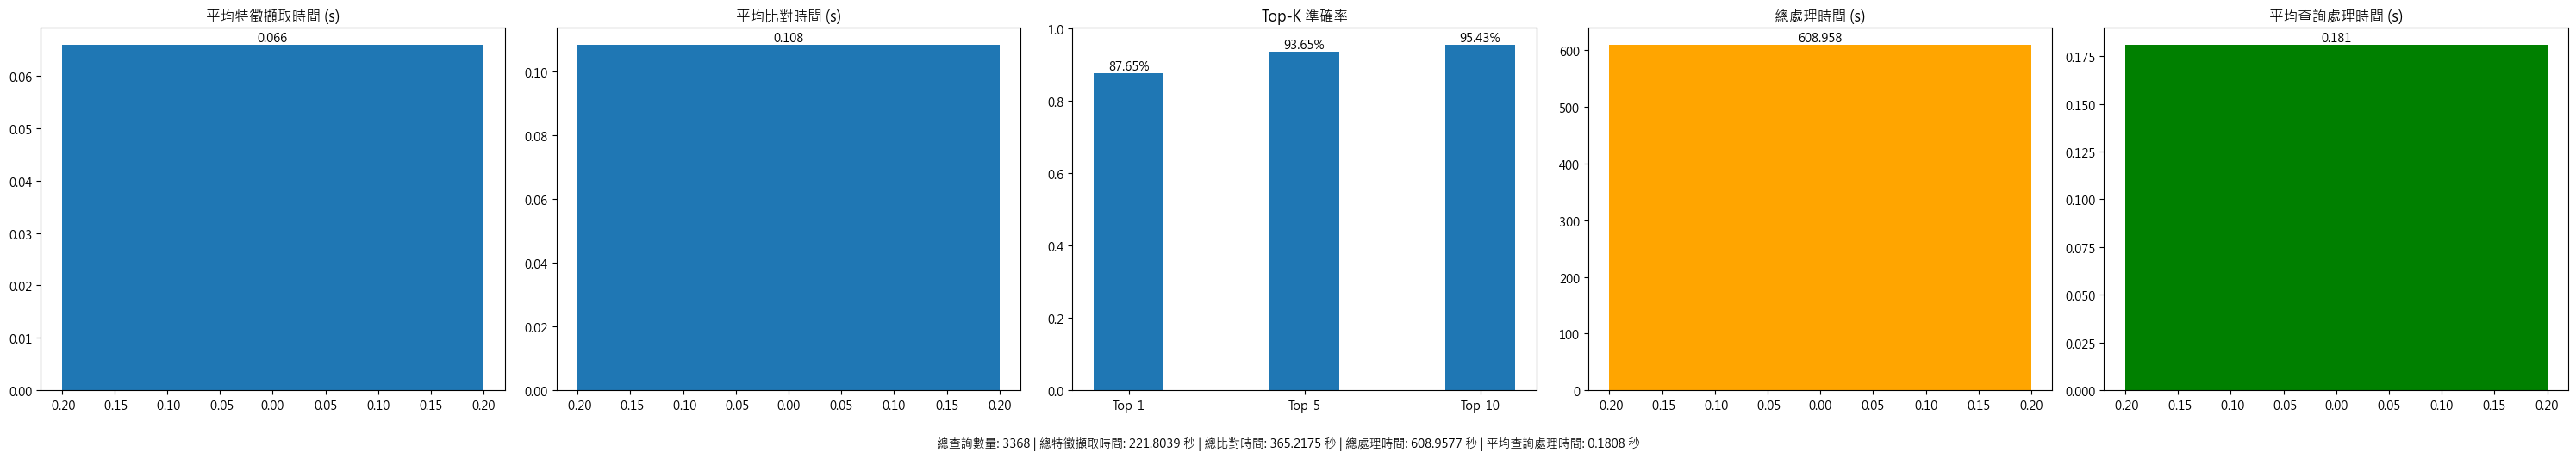

In [1]:
import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from radio_feature_processor import RADIOFeatureProcessor

# 設定字體，確保能同時顯示中文與英文
# 可視環境中安裝的字體名稱自行增減
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [
    "SimHei",            # for Windows/Mac/Linux (若有安裝)
    "Microsoft JhengHei",# for Windows (若有安裝)
    "PingFang TC",       # for Mac (若有安裝)
    "Taipei Sans TC Beta",
    "Arial",             # 英文字體 fallback
]
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

class Market1501FullEvaluator:
    def __init__(self, radio_processor, dataset_path):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        
        # 特徵快取
        self.feature_cache = {}
        
    def _get_person_id(self, img_name):
        """根據影像檔名，擷取人物 ID（可能是前 4 碼），
           也可依實際規則調整。"""
        return img_name.split('_')[0]  # 常見切割方式

    def extract_features(self, image_path):
        """提取圖像特徵，並作快取以避免重覆處理"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]
    
    def evaluate(self):
        """
        執行完整 Market-1501 測試，計算 Top-K 準確率 (1, 5, 10)
        回傳 (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, result_detail_df, 
              total_feat_time, total_match_time, total_deal_time)
        """
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        total_feat_time = 0.0
        total_match_time = 0.0
        top1_correct = 0
        top5_correct = 0
        top10_correct = 0
        results = []
        
        print(f"共發現 {len(query_files)} 張查詢影像，即將進行完整測試 ...")
        
        # 預先提取 gallery 特徵
        print("提取 gallery 特徵 ...")
        for gf in tqdm(gallery_files, desc="Gallery feature extraction"):
            _ = self.extract_features(gf)
        
        # 開始對每個 query 進行評估
        print("開始對每個 query 進行比對並評估 ...")
        t4 = time.time()
        
        for qf in tqdm(query_files, desc="Evaluating queries"):
            q_name = qf.name
            q_id = self._get_person_id(q_name)
            
            # 特徵擷取時間
            t0 = time.time()
            q_feat = self.extract_features(qf)
            t1 = time.time()
            feat_time = t1 - t0
            
            # 比對時間
            t2 = time.time()
            similarities = []
            for gf in gallery_files:
                g_name = gf.name
                g_id = self._get_person_id(g_name)
                g_feat = self.extract_features(gf)
                sim = float(np.dot(q_feat.flatten(), g_feat.flatten()))
                similarities.append((sim, g_id))
            t3 = time.time()
            match_time = t3 - t2
            
            # 排序相似度（由大到小）
            similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
            
            # 計算 Top-K 是否正確
            top1_correct += (similarities[0][1] == q_id)
            top5_correct += any(sim[1] == q_id for sim in similarities[:5])
            top10_correct += any(sim[1] == q_id for sim in similarities[:10])
            
            total_feat_time += feat_time
            total_match_time += match_time
            
            results.append({
                'query_name': q_name,
                'query_id': q_id,
                'top1_correct': similarities[0][1] == q_id,
            })
        
        total_deal_time = time.time() - t4
        
        # 統計
        avg_feat_time = total_feat_time / len(query_files)
        avg_match_time = total_match_time / len(query_files)
        top1_acc = top1_correct / len(query_files)
        top5_acc = top5_correct / len(query_files)
        top10_acc = top10_correct / len(query_files)
        
        detail_df = pd.DataFrame(results)
        
        return (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
                detail_df, total_feat_time, total_match_time, total_deal_time)


def run_and_plot(model_version, dataset_path):
    """
    更新圖表，顯示 Top-1, Top-5, Top-10 準確率、總處理時間與平均處理時間
    並將總時間與資料筆數顯示於圖表下方
    """
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    evaluator = Market1501FullEvaluator(radio_processor, dataset_path)
    
    # 修正：接收所有 9 個返回值
    (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
     detail_df, total_feat_time, total_match_time, total_deal_time) = evaluator.evaluate()
    
    # 計算平均 query 處理時間
    avg_query_time = total_deal_time / len(detail_df)
    
    print(f"\n=== 評估結果 (Model: {model_version}) ===")
    print(f"平均特徵擷取時間: {avg_feat_time:.4f} 秒")
    print(f"平均比對時間: {avg_match_time:.4f} 秒")
    print(f"平均查詢處理時間: {avg_query_time:.4f} 秒")
    print(f"Top-1 準確率: {top1_acc:.2%}")
    print(f"Top-5 準確率: {top5_acc:.2%}")
    print(f"Top-10 準確率: {top10_acc:.2%}")
    print(f"總特徵擷取時間: {total_feat_time:.4f} 秒")
    print(f"總比對時間: {total_match_time:.4f} 秒")
    print(f"總處理時間: {total_deal_time:.4f} 秒")
    print(f"總查詢影像數量: {len(detail_df)}")
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 5))
    
    # 平均特徵擷取時間
    axes[0].bar([0], [avg_feat_time], width=0.4)
    axes[0].set_title("平均特徵擷取時間 (s)")
    axes[0].text(0, avg_feat_time, f"{avg_feat_time:.3f}", ha='center', va='bottom')
    
    # 平均比對時間
    axes[1].bar([0], [avg_match_time], width=0.4)
    axes[1].set_title("平均比對時間 (s)")
    axes[1].text(0, avg_match_time, f"{avg_match_time:.3f}", ha='center', va='bottom')
    
    # Top-K 準確率
    axes[2].bar([0, 1, 2], [top1_acc, top5_acc, top10_acc], width=0.4, tick_label=["Top-1", "Top-5", "Top-10"])
    axes[2].set_title("Top-K 準確率")
    for i, acc in enumerate([top1_acc, top5_acc, top10_acc]):
        axes[2].text(i, acc, f"{acc:.2%}", ha='center', va='bottom')
    
    # 總處理時間
    axes[3].bar([0], [total_deal_time], width=0.4, color='orange')
    axes[3].set_title("總處理時間 (s)")
    axes[3].text(0, total_deal_time, f"{total_deal_time:.3f}", ha='center', va='bottom')
    
    # 平均查詢處理時間
    axes[4].bar([0], [avg_query_time], width=0.4, color='green')
    axes[4].set_title("平均查詢處理時間 (s)")
    axes[4].text(0, avg_query_time, f"{avg_query_time:.3f}", ha='center', va='bottom')
    
    # 加入文字註解
    fig.text(0.5, -0.05, 
             f"總查詢數量: {len(detail_df)} | 總特徵擷取時間: {total_feat_time:.4f} 秒 | " \
             f"總比對時間: {total_match_time:.4f} 秒 | 總處理時間: {total_deal_time:.4f} 秒 | " \
             f"平均查詢處理時間: {avg_query_time:.4f} 秒",
             ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"

    # 指定要評估的模型版本
    model_version = "radio_v2.5-l"
     #"radio_v2.5-g"
     #"e-radio_v2"
     #radio_v2.1
     
    # 執行測試並輸出圖表
    run_and_plot(model_version, dataset_path)

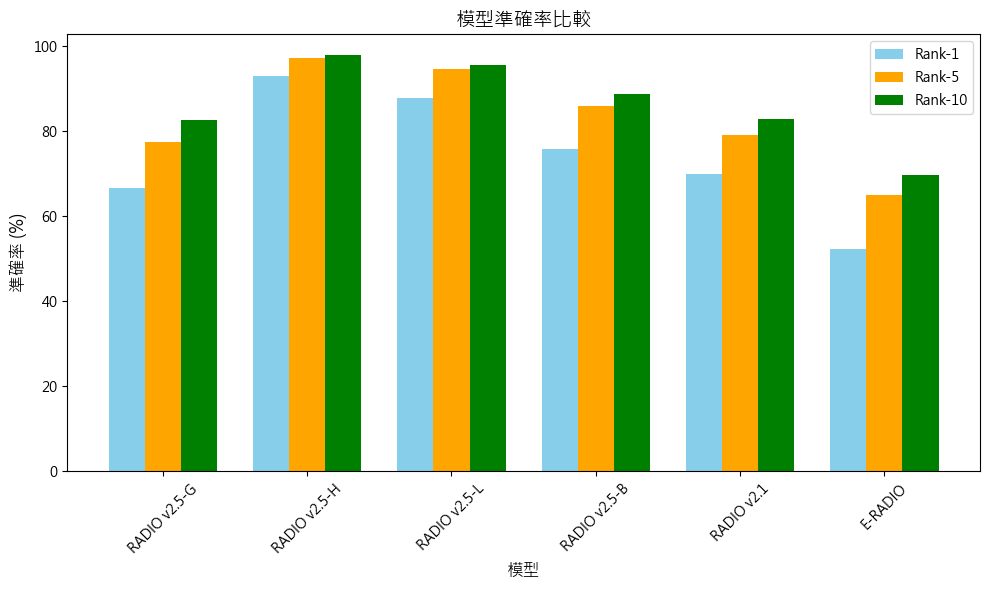

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名稱
models = ['RADIO v2.5-G', 'RADIO v2.5-H', 'RADIO v2.5-L', 'RADIO v2.5-B', 'RADIO v2.1', 'E-RADIO']

# 準確率數據
rank_1 = [66.48, 92.99, 87.65, 75.68, 69.80, 52.20]
rank_5 = [77.49, 97.18, 94.65, 85.93, 79.04, 65.02]
rank_10 = [82.45, 97.80, 95.43, 88.78, 82.90, 69.54]

x = np.arange(len(models))  # x 軸刻度位置
width = 0.25  # 長條寬度

# 繪製長條圖
plt.figure(figsize=(10, 6))
plt.bar(x - width, rank_1, width, label='Rank-1', color='skyblue')
plt.bar(x, rank_5, width, label='Rank-5', color='orange')
plt.bar(x + width, rank_10, width, label='Rank-10', color='green')

# 添加標籤和標題
plt.xlabel('模型', fontsize=12)
plt.ylabel('準確率 (%)', fontsize=12)
plt.title('模型準確率比較', fontsize=14)
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

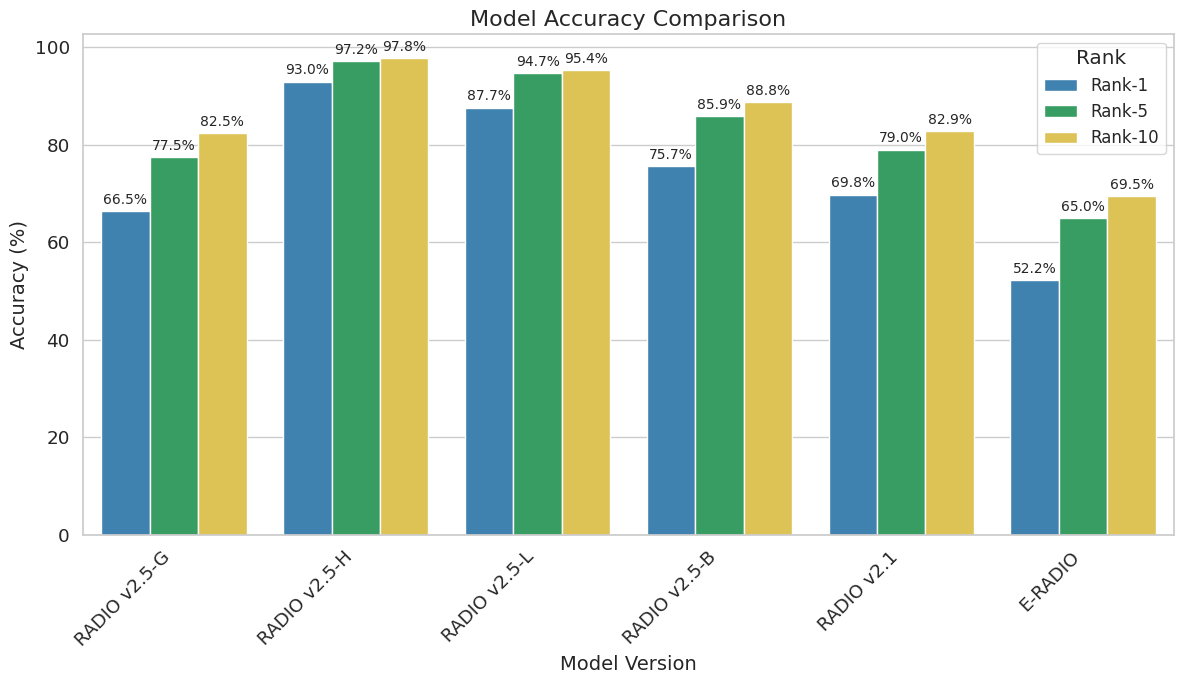

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm

# 設置字體大小
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

data = {
   "Model Version": ["RADIO v2.5-G", "RADIO v2.5-H", "RADIO v2.5-L", "RADIO v2.5-B", "RADIO v2.1", "E-RADIO"],
   "Rank-1": [66.48, 92.99, 87.65, 75.68, 69.80, 52.20],
   "Rank-5": [77.49, 97.18, 94.65, 85.93, 79.04, 65.02],
   "Rank-10": [82.45, 97.80, 95.43, 88.78, 82.90, 69.54]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars="Model Version", 
                   value_vars=["Rank-1", "Rank-5", "Rank-10"],
                   var_name="Rank",
                   value_name="Accuracy")

plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(x="Model Version", 
                     y="Accuracy",
                     hue="Rank",
                     data=df_melted,
                     palette=["#2E86C1", "#27AE60", "#F4D03F"])

# 調整字體重疊
plt.xticks(rotation=45, ha='right')

# 個別設置每個數值標籤的位置
for container in bar_plot.containers:
   bar_plot.bar_label(container, fmt='%.1f%%', padding=3, 
                     rotation=0, fontsize=10)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model Version")
plt.legend(title="Rank")

# 調整布局避免截斷
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

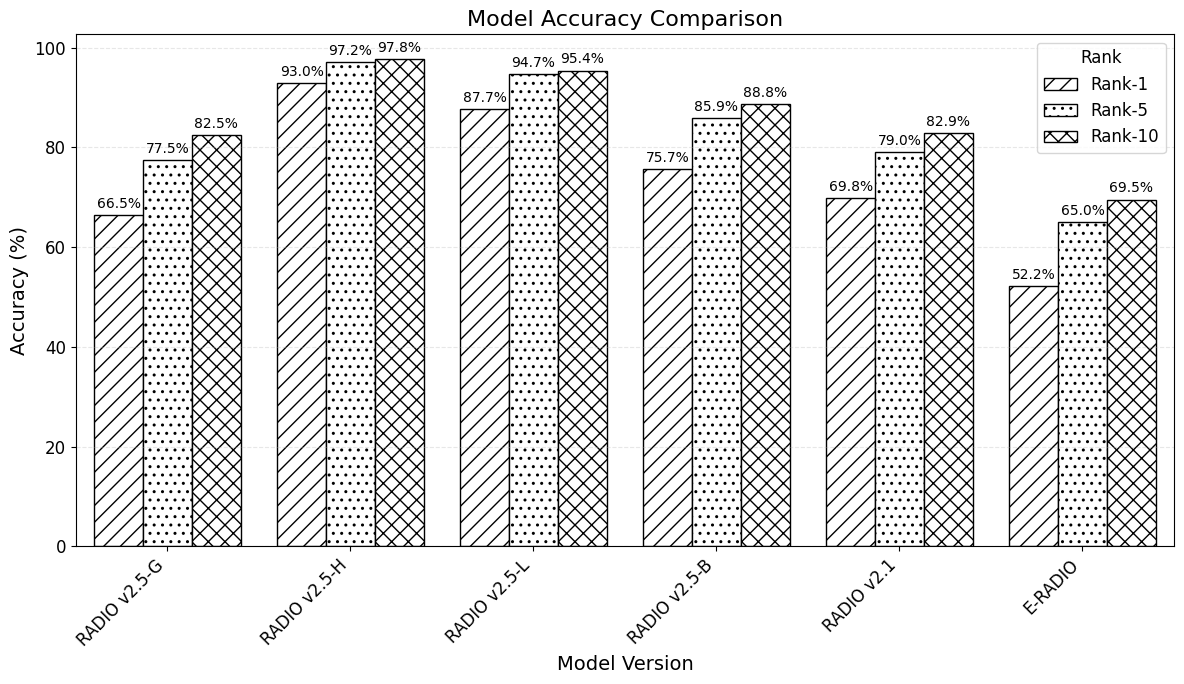

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 設置字體大小
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

data = {
   "Model Version": ["RADIO v2.5-G", "RADIO v2.5-H", "RADIO v2.5-L", "RADIO v2.5-B", "RADIO v2.1", "E-RADIO"],
   "Rank-1": [66.48, 92.99, 87.65, 75.68, 69.80, 52.20],
   "Rank-5": [77.49, 97.18, 94.65, 85.93, 79.04, 65.02],
   "Rank-10": [82.45, 97.80, 95.43, 88.78, 82.90, 69.54]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars="Model Version", 
                   value_vars=["Rank-1", "Rank-5", "Rank-10"],
                   var_name="Rank",
                   value_name="Accuracy")

plt.figure(figsize=(12, 7))

# 使用白色背景和黑色邊框
bar_plot = sns.barplot(x="Model Version", 
                      y="Accuracy",
                      hue="Rank",
                      data=df_melted,
                      palette=["white", "white", "white"],
                      edgecolor="black")

# 定義不同的填充模式
hatches = ['//', '..', 'xx']  # 使用更密集的填充樣式
for i, bars in enumerate(bar_plot.containers):
    for bar in bars:
        bar.set_hatch(hatches[i])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)

# 調整字體重疊
plt.xticks(rotation=45, ha='right')

# 個別設置每個數值標籤的位置
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', padding=3, 
                      rotation=0, fontsize=10)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model Version")

# 修改圖例樣式
legend = plt.legend(title="Rank")
# 為圖例添加對應的填充模式
for i, patch in enumerate(legend.get_patches()):
    patch.set_hatch(hatches[i])
    patch.set_edgecolor('black')
    patch.set_facecolor('white')

# 添加網格線以提高可讀性
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 調整布局避免截斷
plt.tight_layout()
plt.savefig("accuracy_comparison_bw.png", dpi=300, bbox_inches='tight')
plt.show()

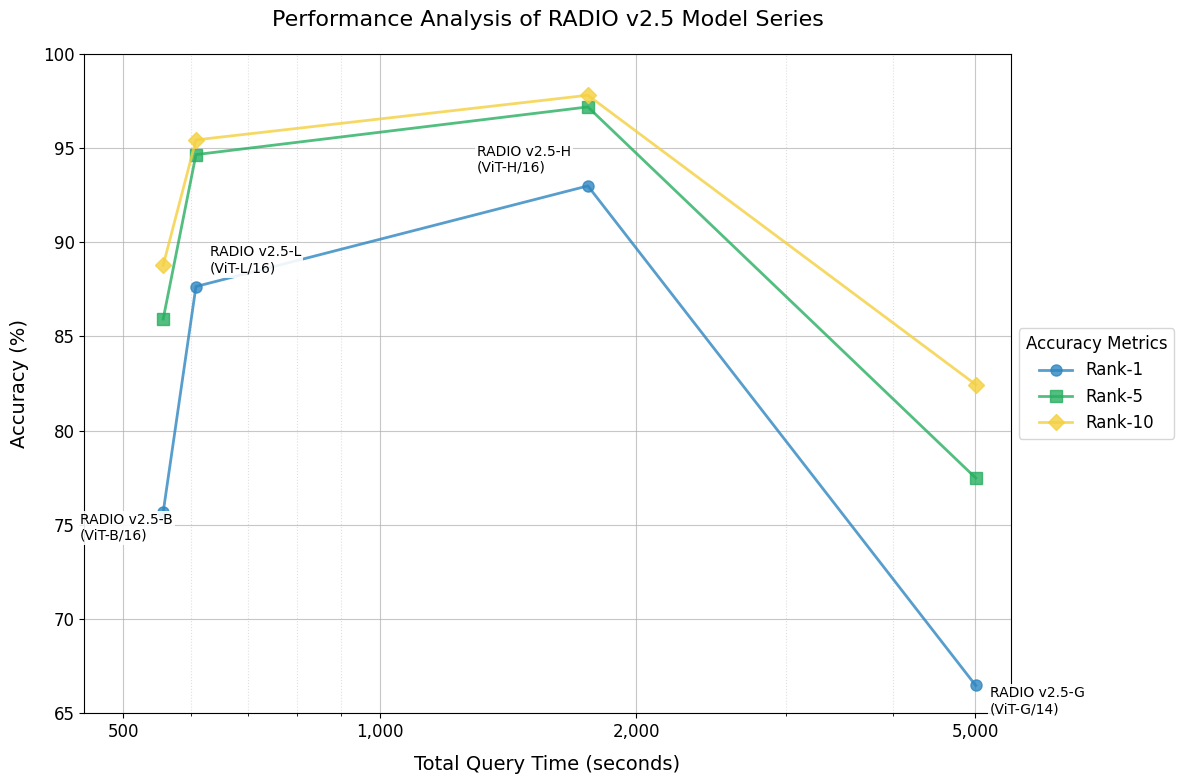

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'figure.figsize': (12, 8)
})

data = {
    "Model": ["RADIO v2.5-B", "RADIO v2.5-L", "RADIO v2.5-H", "RADIO v2.5-G"],
    "Architecture": ["ViT-B/16", "ViT-L/16", "ViT-H/16", "ViT-G/14"],
    "Query Time": [557.01, 608.56, 1754.57, 5003.89],
    "Rank-1": [75.68, 87.65, 92.99, 66.48],
    "Rank-5": [85.93, 94.65, 97.18, 77.49],
    "Rank-10": [88.78, 95.43, 97.80, 82.45]
}

fig, ax = plt.subplots()

# 繪製曲線（保持原樣）
colors = ['#2E86C1', '#27AE60', '#F4D03F']
markers = ['o', 's', 'D']
ranks = ['Rank-1', 'Rank-5', 'Rank-10']

for i, rank in enumerate(ranks):
    ax.plot(data['Query Time'], data[rank], 
            marker=markers[i],
            color=colors[i],
            label=rank,
            linewidth=2,
            markersize=8,
            alpha=0.8)

# 標註模型（保持原樣）
label_positions = [(-60, -20), (10, 10), (-80, 10), (10, -20)]

for i, (time, r1, arch, model) in enumerate(zip(data['Query Time'], 
                                              data['Rank-1'],
                                              data['Architecture'],
                                              data['Model'])):
    ax.annotate(f"{model}\n({arch})",
                xy=(time, r1),
                xytext=label_positions[i],
                textcoords='offset points',
                fontsize=10,
                bbox=dict(facecolor='white', 
                         edgecolor='none', 
                         alpha=0.9,
                         pad=1.5))

# 修正刻度設置：移除手動次要刻度，改用LogFormatter
ax.set_xscale('log')
ax.set_xlim(450, 5500)
ax.set_ylim(65, 100)

# 設置對數軸的格式化程序
from matplotlib.ticker import LogFormatter
ax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))  # 顯示所有主刻度
ax.xaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))  # 隱藏次要刻度標籤

# 強制顯示主刻度標籤
ax.set_xticks([500, 1000, 2000, 5000])
ax.set_xticklabels(['500', '1,000', '2,000', '5,000'])

# 其他設置保持不變
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.set_xlabel('Total Query Time (seconds)', labelpad=10)
ax.set_ylabel('Accuracy (%)', labelpad=10)
ax.set_title('Performance Analysis of RADIO v2.5 Model Series', pad=20)
ax.legend(title='Accuracy Metrics', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('radio_v2.5_comparison_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

| Model        |   Extract (s) |   Recognize (s) |   Rank-1 (%) |   Total (s) |
|--------------|---------------|-----------------|--------------|-------------|
| RADIO v2.5-G |         1.41  |           0.072 |        66.48 |     5003.89 |
| RADIO v2.5-H |         0.413 |           0.193 |        92.99 |     1754.57 |
| RADIO v2.5-L |         0.066 |           0.108 |        87.65 |      608.56 |
| RADIO v2.5-B |         0.053 |           0.106 |        75.68 |      557.01 |
| RADIO v2.1   |         0.084 |           0.139 |        69.8  |      773.86 |
| E-RADIO      |         0.098 |           0.108 |        52.2  |      717.56 |


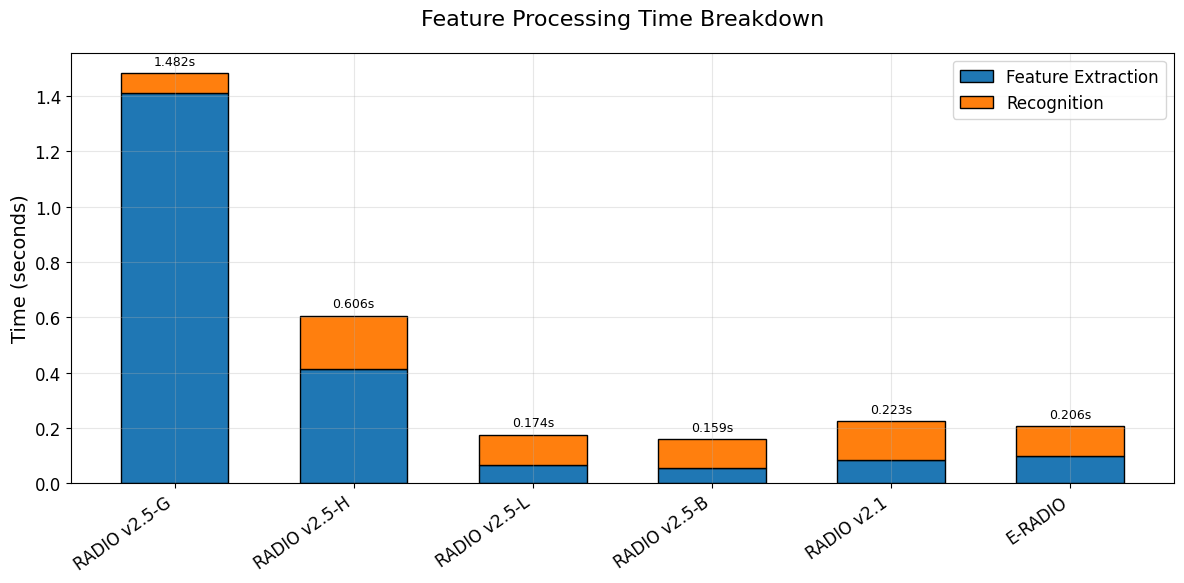

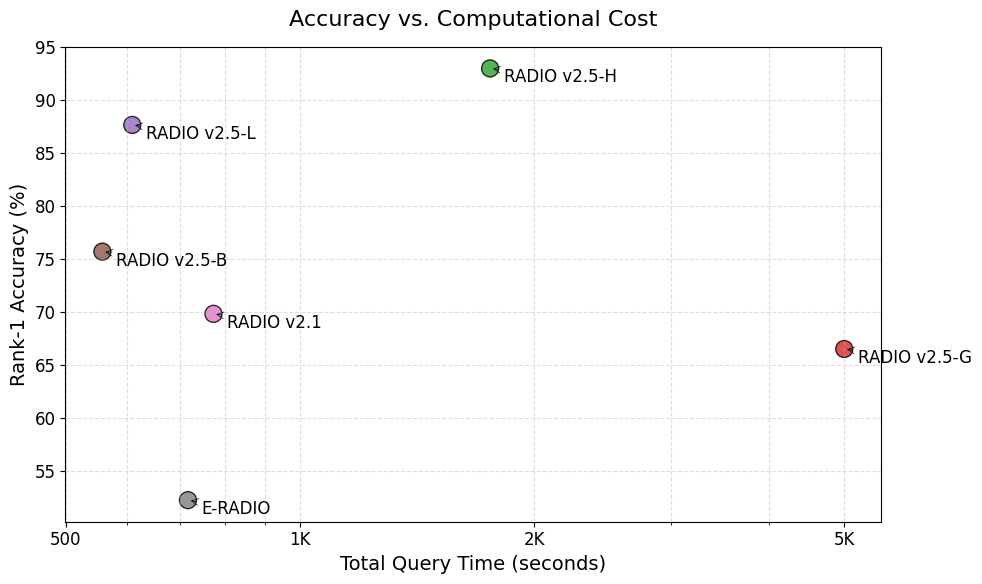

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# ----------------------
# 原始表格數據 (直接引用您提供的資料)
# ----------------------
models = [
    {"name": "RADIO v2.5-G", "extract": 1.410, "recognize": 0.072, "rank1": 66.48, "total": 5003.89},
    {"name": "RADIO v2.5-H", "extract": 0.413, "recognize": 0.193, "rank1": 92.99, "total": 1754.57},
    {"name": "RADIO v2.5-L", "extract": 0.066, "recognize": 0.108, "rank1": 87.65, "total": 608.56},
    {"name": "RADIO v2.5-B", "extract": 0.053, "recognize": 0.106, "rank1": 75.68, "total": 557.01},
    {"name": "RADIO v2.1", "extract": 0.084, "recognize": 0.139, "rank1": 69.80, "total": 773.86},
    {"name": "E-RADIO", "extract": 0.098, "recognize": 0.108, "rank1": 52.20, "total": 717.56}
]

# ----------------------
# 核心分析圖表 (基於原始表格)
# ----------------------
def plot_feature_comparison():
    plt.figure(figsize=(12, 6))
    
    # 數據提取
    names = [m["name"] for m in models]
    extract = [m["extract"] for m in models]
    recognize = [m["recognize"] for m in models]
    x = np.arange(len(names))
    
    # 繪製堆疊柱狀圖
    plt.bar(x, extract, width=0.6, label='Feature Extraction', color='#1f77b4', edgecolor='black')
    plt.bar(x, recognize, width=0.6, bottom=extract, label='Recognition', color='#ff7f0e', edgecolor='black')
    
    # 自動標籤定位
    for i in x:
        total = extract[i] + recognize[i]
        plt.text(i, total + 0.02, f'{total:.3f}s', ha='center', va='bottom', fontsize=9)
    
    # 樣式設定
    plt.xticks(x, names, rotation=35, ha='right')
    plt.ylabel('Time (seconds)')
    plt.title('Feature Processing Time Breakdown', pad=20)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_breakdown.png', dpi=300)

# ----------------------
# 效能-準確率散點圖
# ----------------------
def plot_performance_scatter():
    plt.figure(figsize=(10, 6))
    
    # 數據提取
    total_time = [m["total"] for m in models]
    rank1 = [m["rank1"] for m in models]
    colors = ['#d62728', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # 繪製散點圖
    scatter = plt.scatter(total_time, rank1, s=150, c=colors, edgecolor='black', alpha=0.8)
    
    # 標籤與趨勢線
    for i, txt in enumerate([m["name"] for m in models]):
        plt.annotate(txt, (total_time[i], rank1[i]),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", lw=0.5))
    
    # 對數軸設定
    plt.xscale('log')
    plt.xticks([500, 1000, 2000, 5000], ['500', '1K', '2K', '5K'])
    plt.xlabel('Total Query Time (seconds)')
    plt.ylabel('Rank-1 Accuracy (%)')
    plt.title('Accuracy vs. Computational Cost', pad=15)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig('accuracy_scatter.png', dpi=300)

# ----------------------
# 輸出格式化表格
# ----------------------
def generate_table():
    headers = ["Model", "Extract (s)", "Recognize (s)", "Rank-1 (%)", "Total (s)"]
    rows = [[m["name"], m["extract"], m["recognize"], m["rank1"], m["total"]] for m in models]
    print(tabulate(rows, headers=headers, tablefmt="github", numalign="decimal"))

# 執行所有繪圖與表格
plot_feature_comparison()
plot_performance_scatter()
generate_table()

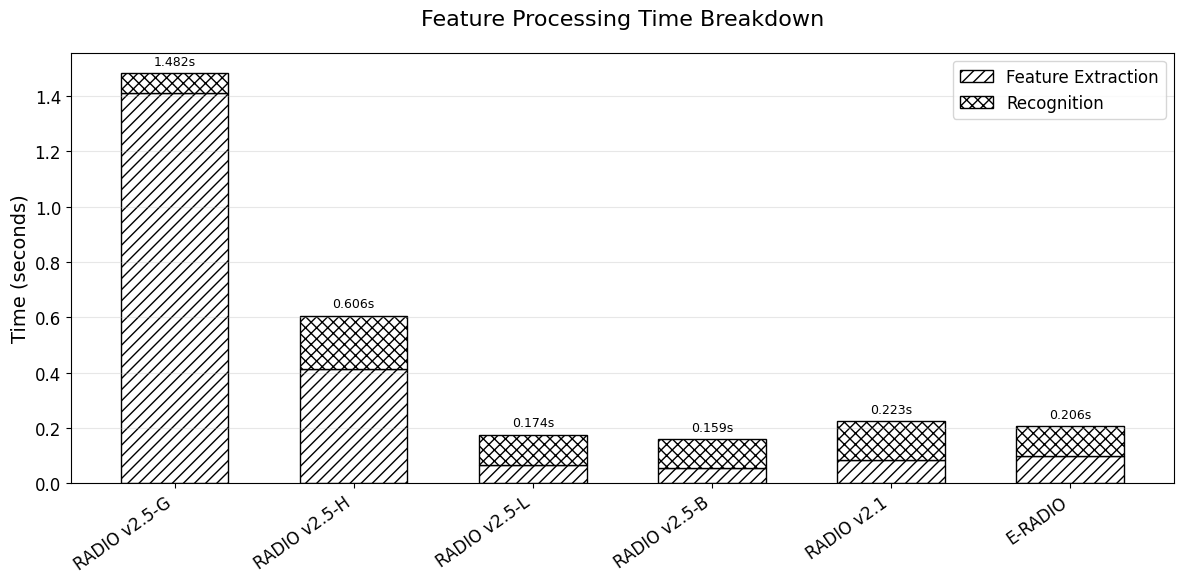

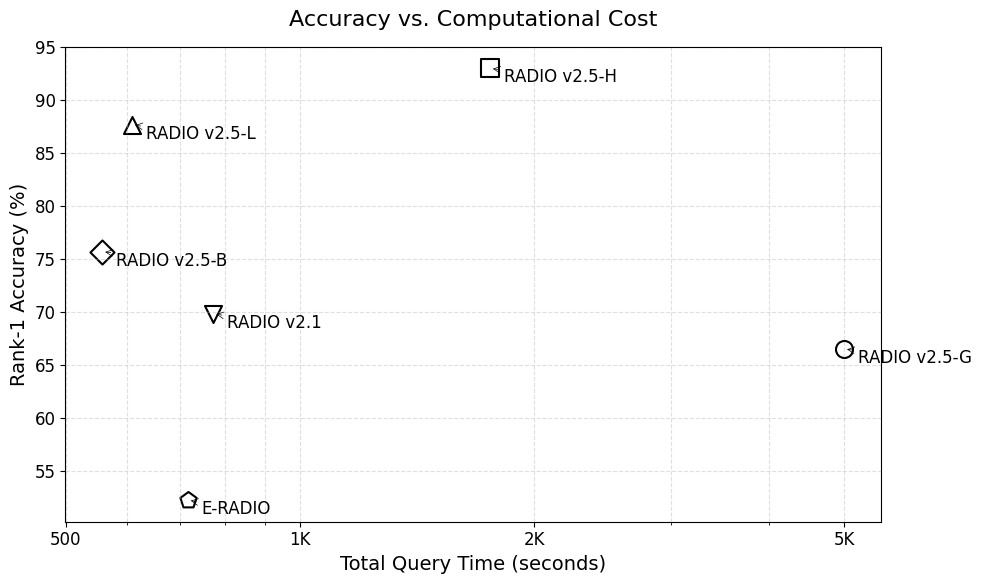

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Original data
models = [
    {"name": "RADIO v2.5-G", "extract": 1.410, "recognize": 0.072, "rank1": 66.48, "total": 5003.89},
    {"name": "RADIO v2.5-H", "extract": 0.413, "recognize": 0.193, "rank1": 92.99, "total": 1754.57},
    {"name": "RADIO v2.5-L", "extract": 0.066, "recognize": 0.108, "rank1": 87.65, "total": 608.56},
    {"name": "RADIO v2.5-B", "extract": 0.053, "recognize": 0.106, "rank1": 75.68, "total": 557.01},
    {"name": "RADIO v2.1", "extract": 0.084, "recognize": 0.139, "rank1": 69.80, "total": 773.86},
    {"name": "E-RADIO", "extract": 0.098, "recognize": 0.108, "rank1": 52.20, "total": 717.56}
]

def plot_feature_comparison():
    plt.figure(figsize=(12, 6))
    
    # Data extraction
    names = [m["name"] for m in models]
    extract = [m["extract"] for m in models]
    recognize = [m["recognize"] for m in models]
    x = np.arange(len(names))
    
    # Create stacked bar chart with patterns
    plt.bar(x, extract, width=0.6, label='Feature Extraction',
            color='white', edgecolor='black', hatch='///')
    plt.bar(x, recognize, width=0.6, bottom=extract, label='Recognition',
            color='white', edgecolor='black', hatch='xxx')
    
    # Add value labels
    for i in x:
        total = extract[i] + recognize[i]
        plt.text(i, total + 0.02, f'{total:.3f}s', ha='center', va='bottom', fontsize=9)
    
    # Styling
    plt.xticks(x, names, rotation=35, ha='right')
    plt.ylabel('Time (seconds)')
    plt.title('Feature Processing Time Breakdown', pad=20)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_breakdown_bw.png', dpi=300, bbox_inches='tight')

def plot_performance_scatter():
    plt.figure(figsize=(10, 6))
    
    # Data extraction
    total_time = [m["total"] for m in models]
    rank1 = [m["rank1"] for m in models]
    
    # Different marker patterns for each point
    markers = ['o', 's', '^', 'D', 'v', 'p']
    
    # Plot scatter with different markers
    for i in range(len(models)):
        plt.scatter(total_time[i], rank1[i], s=150, 
                   marker=markers[i], 
                   facecolor='white',
                   edgecolor='black',
                   linewidth=1.5,
                   label=models[i]["name"])
    
    # Add labels and arrows
    for i, txt in enumerate([m["name"] for m in models]):
        plt.annotate(txt, (total_time[i], rank1[i]),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", lw=0.5))
    
    # Logarithmic scale and styling
    plt.xscale('log')
    plt.xticks([500, 1000, 2000, 5000], ['500', '1K', '2K', '5K'])
    plt.xlabel('Total Query Time (seconds)')
    plt.ylabel('Rank-1 Accuracy (%)')
    plt.title('Accuracy vs. Computational Cost', pad=15)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig('accuracy_scatter_bw.png', dpi=300, bbox_inches='tight')

# Generate plots
plot_feature_comparison()
plot_performance_scatter()

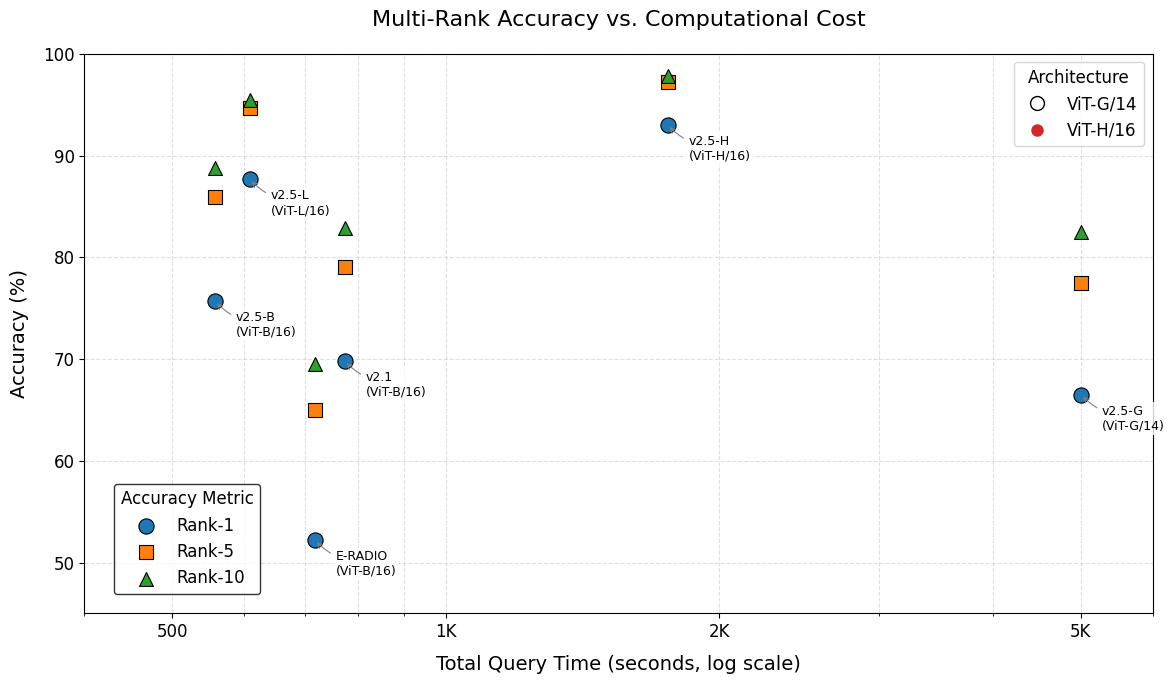

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------
# 数据准备 (直接引用原始表格)
# ----------------------
models = [
    {"name": "v2.5-G", "time": 5003.89, "rank1":66.48, "rank5":77.49, "rank10":82.45, "arch":"ViT-G/14"},
    {"name": "v2.5-H", "time":1754.57, "rank1":92.99, "rank5":97.18, "rank10":97.80, "arch":"ViT-H/16"},
    {"name": "v2.5-L", "time":608.56,  "rank1":87.65, "rank5":94.65, "rank10":95.43, "arch":"ViT-L/16"},
    {"name": "v2.5-B", "time":557.01,  "rank1":75.68, "rank5":85.93, "rank10":88.78, "arch":"ViT-B/16"},
    {"name": "v2.1",   "time":773.86,  "rank1":69.80, "rank5":79.04, "rank10":82.90, "arch":"ViT-B/16"},
    {"name": "E-RADIO","time":717.56,  "rank1":52.20, "rank5":65.02, "rank10":69.54, "arch":"ViT-B/16"}
]

# ----------------------
# 繪製多維度散點圖
# ----------------------
plt.figure(figsize=(12, 7))

# 自定義樣式參數
marker_config = {
    "rank1": {"marker": "o", "size": 120, "color": "#1f77b4", "label": "Rank-1"},
    "rank5": {"marker": "s", "size": 100, "color": "#ff7f0e", "label": "Rank-5"},
    "rank10": {"marker": "^", "size": 100, "color": "#2ca02c", "label": "Rank-10"}
}

# 繪製三層數據點
for rank_type in ["rank1", "rank5", "rank10"]:
    x = [m["time"] for m in models]
    y = [m[rank_type] for m in models]
    plt.scatter(
        x, y,
        s=marker_config[rank_type]["size"],
        marker=marker_config[rank_type]["marker"],
        edgecolors='black',
        linewidths=0.8,
        c=marker_config[rank_type]["color"],
        label=marker_config[rank_type]["label"],
        zorder=3  # 確保在最上層
    )

# 添加模型標籤與架構說明
for model in models:
    plt.annotate(
        f"{model['name']}\n({model['arch']})",
        xy=(model["time"], model["rank1"]),
        xytext=(15, -25),
        textcoords='offset points',
        fontsize=9,
        arrowprops=dict(
            arrowstyle="->",
            connectionstyle="arc3,rad=-0.2",
            color="gray",
            lw=0.8
        ),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
    )

# 對數軸與格線設定
plt.xscale('log')
plt.xticks([500, 1000, 2000, 5000], ['500', '1K', '2K', '5K'])
plt.grid(True, which='both', linestyle='--', alpha=0.4)

# 座標軸範圍設定
plt.ylim(45, 100)
plt.xlim(400, 6000)

# 標題與圖例
plt.title('Multi-Rank Accuracy vs. Computational Cost', pad=20, fontsize=16)
plt.xlabel('Total Query Time (seconds, log scale)', labelpad=10)
plt.ylabel('Accuracy (%)', labelpad=10)

# 雙層圖例設定
legend1 = plt.legend(title="Accuracy Metric", 
                   loc="lower left", 
                   bbox_to_anchor=(0.02, 0.02),
                   frameon=True,
                   edgecolor='black')

# 添加顏色標註說明
arch_legend_elements = [
    plt.Line2D([0], [0], 
              marker='o', 
              color='w', 
              label='ViT-G/14',
              markerfacecolor='none',
              markeredgecolor='black',
              markersize=10),
    plt.Line2D([0], [0], 
              marker='o', 
              color='w', 
              label='ViT-H/16',
              markerfacecolor='#d62728',
              markersize=10),
    # 可依此類推添加其他架構...
]

plt.legend(handles=arch_legend_elements, 
          title="Architecture",
          loc="upper right",
          bbox_to_anchor=(1.00, 1.00))

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig('multi_rank_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
data 

{'Model': ['E-RADIO',
  'RADIO v2.1',
  'RADIO v2.5-B',
  'RADIO v2.5-L',
  'RADIO v2.5-H',
  'RADIO v2.5-G'],
 'Query Time': [717.56, 773.86, 557.01, 608.56, 1754.57, 5003.89],
 'Rank-1': [52.2, 69.8, 75.68, 87.65, 92.99, 66.48],
 'Rank-5': [65.02, 79.04, 85.93, 94.65, 97.18, 77.49],
 'Rank-10': [69.54, 82.9, 88.78, 95.43, 97.8, 82.45]}

In [17]:
plt.show()


Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
No pretrained configuration specified for vit_huge_patch16_224 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


KeyboardInterrupt: 

Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
No pretrained configuration specified for vit_huge_patch16_224 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


Model hash: e19fd4730a3aa318217eab19c92a5a91
Model output type: <class 'radio.adaptor_base.RadioOutput'>
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 3840])
Created new FAISS index for face with dimension 3840
Created new FAISS index for body with dimension 3840
No cached features found for face
No cached features found for body
共發現 3368 張查詢影像，即將進行完整測試 ...
提取 gallery 特徵 ...


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

開始對每個 query 進行比對並評估 ...


Evaluating queries:   0%|          | 0/3368 [00:00<?, ?it/s]


=== 評估結果 (Model: radio_v2.5-h) ===
平均特徵擷取時間: 1.2520 秒
平均比對時間: 0.1065 秒
平均查詢處理時間: 1.3642 秒
Top-1 準確率: 92.99%
Top-5 準確率: 97.18%
Top-10 準確率: 97.83%
總特徵擷取時間: 4216.7060 秒
總比對時間: 358.7215 秒
總處理時間: 4594.5357 秒
總查詢影像數量: 3368


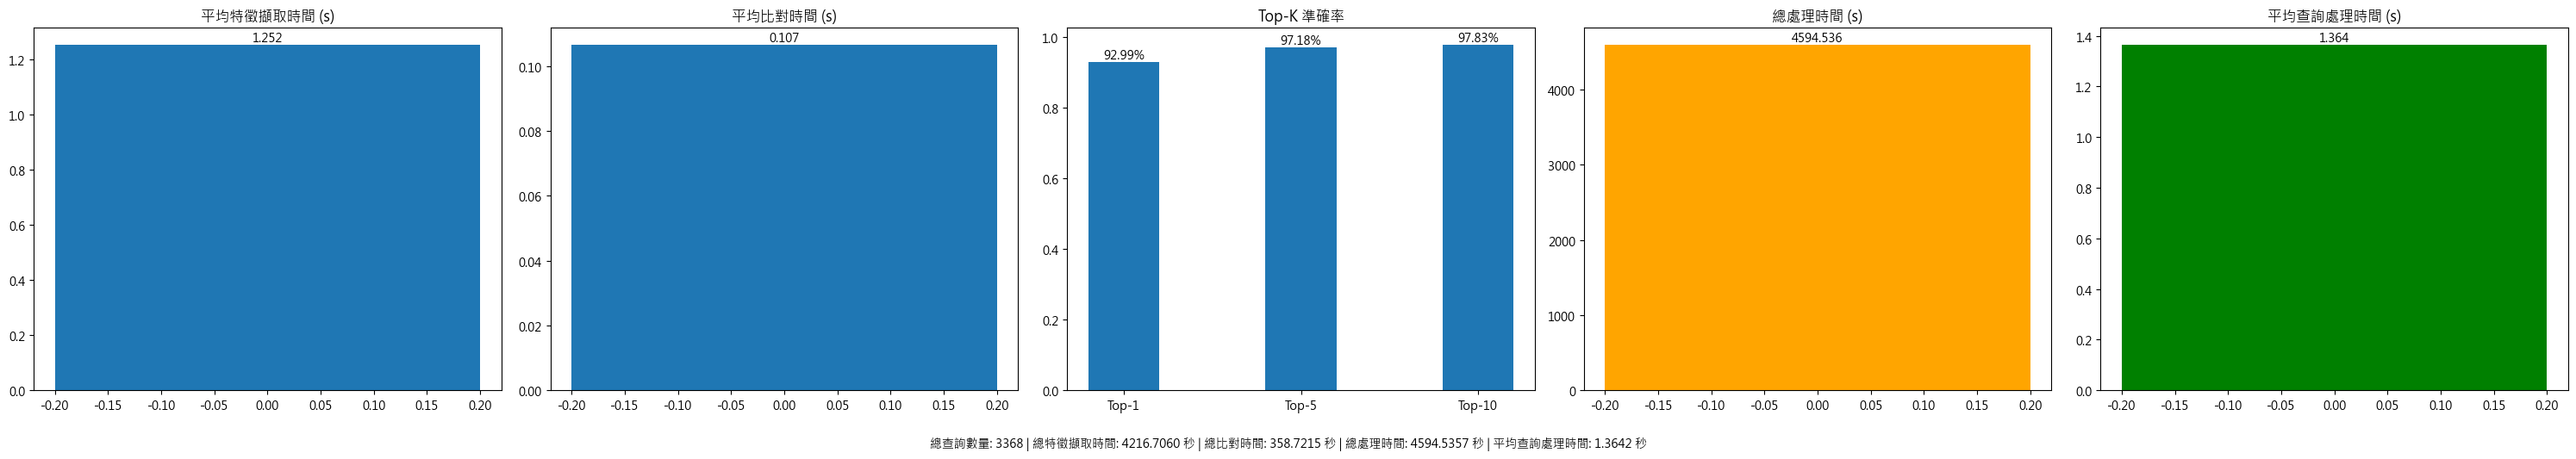

In [5]:
import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from radio_feature_processor import RADIOFeatureProcessor

# 設定字體，確保能同時顯示中文與英文
# 可視環境中安裝的字體名稱自行增減
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [
    "SimHei",            # for Windows/Mac/Linux (若有安裝)
    "Microsoft JhengHei",# for Windows (若有安裝)
    "PingFang TC",       # for Mac (若有安裝)
    "Taipei Sans TC Beta",
    "Arial",             # 英文字體 fallback
]
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

class Market1501FullEvaluator:
    def __init__(self, radio_processor, dataset_path):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        
        # 特徵快取
        self.feature_cache = {}
        
    def _get_person_id(self, img_name):
        """根據影像檔名，擷取人物 ID（可能是前 4 碼），
           也可依實際規則調整。"""
        return img_name.split('_')[0]  # 常見切割方式

    def extract_features(self, image_path):
        """提取圖像特徵，並作快取以避免重覆處理"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]
    
    def evaluate(self):
        """
        執行完整 Market-1501 測試，計算 Top-K 準確率 (1, 5, 10)
        回傳 (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, result_detail_df, 
              total_feat_time, total_match_time, total_deal_time)
        """
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        total_feat_time = 0.0
        total_match_time = 0.0
        top1_correct = 0
        top5_correct = 0
        top10_correct = 0
        results = []
        
        print(f"共發現 {len(query_files)} 張查詢影像，即將進行完整測試 ...")
        
        # 預先提取 gallery 特徵
        print("提取 gallery 特徵 ...")
        for gf in tqdm(gallery_files, desc="Gallery feature extraction"):
            _ = self.extract_features(gf)
        
        # 開始對每個 query 進行評估
        print("開始對每個 query 進行比對並評估 ...")
        t4 = time.time()
        
        for qf in tqdm(query_files, desc="Evaluating queries"):
            q_name = qf.name
            q_id = self._get_person_id(q_name)
            
            # 特徵擷取時間
            t0 = time.time()
            q_feat = self.extract_features(qf)
            t1 = time.time()
            feat_time = t1 - t0
            
            # 比對時間
            t2 = time.time()
            similarities = []
            for gf in gallery_files:
                g_name = gf.name
                g_id = self._get_person_id(g_name)
                g_feat = self.extract_features(gf)
                sim = float(np.dot(q_feat.flatten(), g_feat.flatten()))
                similarities.append((sim, g_id))
            t3 = time.time()
            match_time = t3 - t2
            
            # 排序相似度（由大到小）
            similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
            
            # 計算 Top-K 是否正確
            top1_correct += (similarities[0][1] == q_id)
            top5_correct += any(sim[1] == q_id for sim in similarities[:5])
            top10_correct += any(sim[1] == q_id for sim in similarities[:10])
            
            total_feat_time += feat_time
            total_match_time += match_time
            
            results.append({
                'query_name': q_name,
                'query_id': q_id,
                'top1_correct': similarities[0][1] == q_id,
            })
        
        total_deal_time = time.time() - t4
        
        # 統計
        avg_feat_time = total_feat_time / len(query_files)
        avg_match_time = total_match_time / len(query_files)
        top1_acc = top1_correct / len(query_files)
        top5_acc = top5_correct / len(query_files)
        top10_acc = top10_correct / len(query_files)
        
        detail_df = pd.DataFrame(results)
        
        return (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
                detail_df, total_feat_time, total_match_time, total_deal_time)


def run_and_plot(model_version, dataset_path):
    """
    更新圖表，顯示 Top-1, Top-5, Top-10 準確率、總處理時間與平均處理時間
    並將總時間與資料筆數顯示於圖表下方
    """
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    evaluator = Market1501FullEvaluator(radio_processor, dataset_path)
    
    # 修正：接收所有 9 個返回值
    (avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, 
     detail_df, total_feat_time, total_match_time, total_deal_time) = evaluator.evaluate()
    
    # 計算平均 query 處理時間
    avg_query_time = total_deal_time / len(detail_df)
    
    print(f"\n=== 評估結果 (Model: {model_version}) ===")
    print(f"平均特徵擷取時間: {avg_feat_time:.4f} 秒")
    print(f"平均比對時間: {avg_match_time:.4f} 秒")
    print(f"平均查詢處理時間: {avg_query_time:.4f} 秒")
    print(f"Top-1 準確率: {top1_acc:.2%}")
    print(f"Top-5 準確率: {top5_acc:.2%}")
    print(f"Top-10 準確率: {top10_acc:.2%}")
    print(f"總特徵擷取時間: {total_feat_time:.4f} 秒")
    print(f"總比對時間: {total_match_time:.4f} 秒")
    print(f"總處理時間: {total_deal_time:.4f} 秒")
    print(f"總查詢影像數量: {len(detail_df)}")
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 5))
    
    # 平均特徵擷取時間
    axes[0].bar([0], [avg_feat_time], width=0.4)
    axes[0].set_title("平均特徵擷取時間 (s)")
    axes[0].text(0, avg_feat_time, f"{avg_feat_time:.3f}", ha='center', va='bottom')
    
    # 平均比對時間
    axes[1].bar([0], [avg_match_time], width=0.4)
    axes[1].set_title("平均比對時間 (s)")
    axes[1].text(0, avg_match_time, f"{avg_match_time:.3f}", ha='center', va='bottom')
    
    # Top-K 準確率
    axes[2].bar([0, 1, 2], [top1_acc, top5_acc, top10_acc], width=0.4, tick_label=["Top-1", "Top-5", "Top-10"])
    axes[2].set_title("Top-K 準確率")
    for i, acc in enumerate([top1_acc, top5_acc, top10_acc]):
        axes[2].text(i, acc, f"{acc:.2%}", ha='center', va='bottom')
    
    # 總處理時間
    axes[3].bar([0], [total_deal_time], width=0.4, color='orange')
    axes[3].set_title("總處理時間 (s)")
    axes[3].text(0, total_deal_time, f"{total_deal_time:.3f}", ha='center', va='bottom')
    
    # 平均查詢處理時間
    axes[4].bar([0], [avg_query_time], width=0.4, color='green')
    axes[4].set_title("平均查詢處理時間 (s)")
    axes[4].text(0, avg_query_time, f"{avg_query_time:.3f}", ha='center', va='bottom')
    
    # 加入文字註解
    fig.text(0.5, -0.05, 
             f"總查詢數量: {len(detail_df)} | 總特徵擷取時間: {total_feat_time:.4f} 秒 | " \
             f"總比對時間: {total_match_time:.4f} 秒 | 總處理時間: {total_deal_time:.4f} 秒 | " \
             f"平均查詢處理時間: {avg_query_time:.4f} 秒",
             ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"

    # 指定要評估的模型版本
    model_version = "radio_v2.5-h"
     #"radio_v2.5-g"
     #"e-radio_v2"
     #radio_v2.1
     
    # 執行測試並輸出圖表
    run_and_plot(model_version, dataset_path)

Loading RADIO model...


Using cache found in C:\Users\felix/.cache\torch\hub\NVlabs_RADIO_main
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Model output type: <class 'dict'>
Output keys: dict_keys(['backbone', 'siglip'])
Summary type: <class 'torch.Tensor'>
Summary shape: torch.Size([1, 2304])
Initialized FAISS index
共發現 3368 張查詢影像，即將進行完整測試 ...
提取 gallery 特徵 ...


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

lennnn:  19732


Gallery feature extraction:   0%|          | 0/19732 [00:00<?, ?it/s]

開始對每個 query 進行比對並評估 ...


Evaluating queries:   0%|          | 0/3368 [00:00<?, ?it/s]


=== 顯示辨識結果範例 ===

查詢影像: 0473_c4s2_050698_00.jpg


C:\Users\felix\AppData\Local\Temp\ipykernel_172812\382573349.py:56: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
C:\Users\felix\AppData\Local\Temp\ipykernel_172812\382573349.py:56: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\felix\Desktop\master\face\FP\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


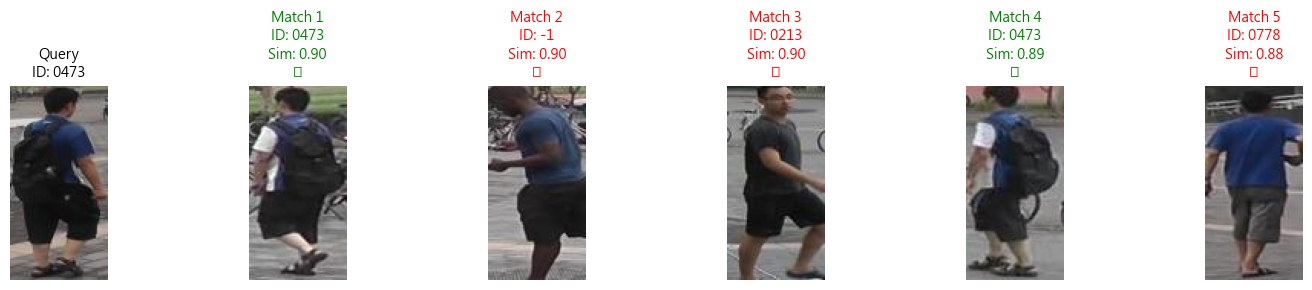


查詢影像: 1203_c1s6_023271_00.jpg


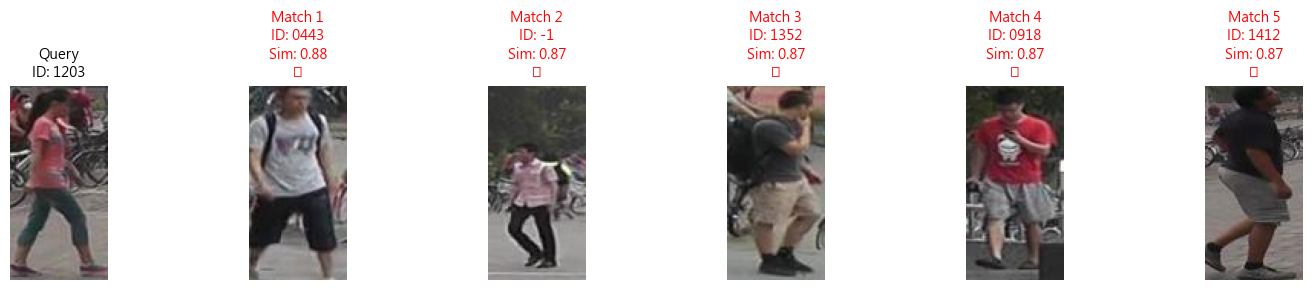


查詢影像: 1122_c1s5_021086_00.jpg


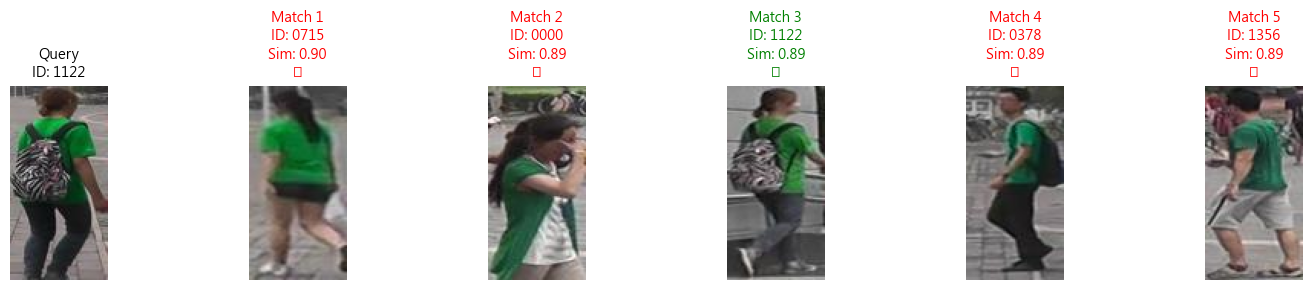

In [3]:
#接續上面那格


import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from PIL import Image

#

def plot_reid_matches(evaluator, query_file, top_k=5, figsize=(15, 3)):
    """
    顯示單一查詢影像的重識別結果
    
    Parameters:
        evaluator: Market1501FullEvaluator 實例
        query_file: 查詢影像路徑
        top_k: 要顯示的最佳匹配數量
        figsize: 圖表大小
    """
    # 取得查詢影像的特徵和ID
    query_id = evaluator._get_person_id(Path(query_file).name)
    query_feat = evaluator.extract_features(query_file)
    
    # 計算與gallery的相似度
    similarities = []
    for gf in evaluator.gallery_path.glob('*.jpg'):
        g_id = evaluator._get_person_id(gf.name)
        g_feat = evaluator.extract_features(gf)
        sim = float(np.dot(query_feat.flatten(), g_feat.flatten()))
        similarities.append((sim, g_id, gf))
    
    # 排序並取得前K個結果
    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
    top_matches = similarities[:top_k]
    
    # 創建圖表
    fig, axes = plt.subplots(1, top_k + 1, figsize=figsize)
    
    # 顯示查詢影像
    query_img = Image.open(query_file)
    axes[0].imshow(query_img)
    axes[0].set_title(f'Query\nID: {query_id}', fontsize=10)
    axes[0].axis('off')
    
    # 顯示匹配結果
    for idx, (sim, g_id, g_path) in enumerate(top_matches, 1):
        gallery_img = Image.open(g_path)
        axes[idx].imshow(gallery_img)
        match_status = '✓' if g_id == query_id else '✗'
        axes[idx].set_title(f'Match {idx}\nID: {g_id}\nSim: {sim:.2f}\n{match_status}', 
                          fontsize=10,
                          color='green' if g_id == query_id else 'red')
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig

def visualize_random_queries(evaluator, num_queries=5, top_k=5):
    """
    隨機選擇幾個查詢影像並顯示其重識別結果
    
    Parameters:
        evaluator: Market1501FullEvaluator 實例
        num_queries: 要顯示的查詢影像數量
        top_k: 每個查詢要顯示的最佳匹配數量
    """
    # 取得所有查詢影像
    query_files = list(evaluator.query_path.glob('*.jpg'))
    
    # 隨機選擇查詢影像
    selected_queries = np.random.choice(query_files, size=min(num_queries, len(query_files)), replace=False)
    
    # 為每個查詢顯示結果
    for query_file in selected_queries:
        print(f"\n查詢影像: {query_file.name}")
        plot_reid_matches(evaluator, query_file, top_k=top_k)
        plt.show()

# 擴展原有的 run_and_plot 函數
def run_and_plot_with_examples(model_version, dataset_path, num_examples=3):
    """
    執行評估，顯示統計圖表，並展示一些辨識結果範例
    """
    radio_processor = RADIOFeatureProcessor(model_version=model_version)
    evaluator = Market1501FullEvaluator(radio_processor, dataset_path)
    
    # 執行原有的評估和繪圖
    results = evaluator.evaluate()
    avg_feat_time, avg_match_time, top1_acc, top5_acc, top10_acc, detail_df, total_feat_time, total_match_time = results
    
    # 顯示一些辨識結果範例
    print("\n=== 顯示辨識結果範例 ===")
    visualize_random_queries(evaluator, num_queries=num_examples)
    
    return evaluator, results

if __name__ == "__main__":
    # 指定 Market-1501 資料集路徑
    dataset_path = "./Market-1501-v15.09.15"
    model_version = "radio_v2.5-b"
    
    # 執行測試並顯示結果
    evaluator, results = run_and_plot_with_examples(model_version, dataset_path)

In [ ]:
print(tqdm(gallery_files, desc="Gallery feature extraction"))

In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd

class Market1501SimpleDebugger:
    def __init__(self, radio_processor, dataset_path, num_samples=10):
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        self.num_samples = num_samples
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        self.gt_path = self.dataset_path / "gt_query"
        
        # 特徵緩存
        self.feature_cache = {}

    def _get_person_id(self, img_name):
        """獲取圖像的人物ID"""
        return img_name[:4]

    def extract_features(self, image_path):
        """提取圖像特徵"""
        if str(image_path) not in self.feature_cache:
            features = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = features
        return self.feature_cache[str(image_path)]

    def debug_evaluation(self):
        """執行簡單的調試評估"""
        # 選擇10個查詢樣本
        query_files = list(self.query_path.glob('*.jpg'))
        selected_queries = np.random.choice(query_files, self.num_samples, replace=False)
        
        overall_results = []
        correct_count = 0
        
        print(f"開始評估 {self.num_samples} 個查詢樣本...")
        
        for query_path in tqdm(selected_queries, desc="處理查詢樣本"):
            query_name = query_path.name
            query_id = self._get_person_id(query_name)
            query_feature = self.extract_features(query_path)
            
            # 與gallery中的所有圖像比對
            similarities = []
            gallery_files = list(self.gallery_path.glob('*.jpg'))
            
            for gallery_path in gallery_files:
                gallery_name = gallery_path.name
                gallery_id = self._get_person_id(gallery_name)
                gallery_feature = self.extract_features(gallery_path)
                
                similarity = float(np.dot(query_feature.flatten(), gallery_feature.flatten()))
                similarities.append({
                    'gallery_name': gallery_name,
                    'similarity': similarity,
                    'is_match': gallery_id == query_id
                })
            
            # 根據相似度排序並取前10個結果
            top_matches = sorted(similarities, key=lambda x: x['similarity'], reverse=True)[:]
            
            # 檢查第一個匹配是否正確
            if top_matches[0]['is_match']:
                correct_count += 1
            
            # 顯示當前查詢的結果
            print(f"\n查詢圖像: {query_name} (ID: {query_id})")
            results_df = pd.DataFrame(top_matches)
            print(results_df)
            
            overall_results.append({
                'query_name': query_name,
                'query_id': query_id,
                'top1_correct': top_matches[0]['is_match']
            })
        
        # 計算並顯示最終準確率
        accuracy = correct_count / self.num_samples
        print(f"\n最終準確率: {accuracy:.2%} ({correct_count}/{self.num_samples})")
        
        return pd.DataFrame(overall_results)

# 使用示例
if __name__ == "__main__":
    from radio_feature_processor import RADIOFeatureProcessor
    
    # 初始化
    radio_processor = RADIOFeatureProcessor()
    debugger = Market1501SimpleDebugger(radio_processor, "./Market-1501-v15.09.15")
    
    # 運行調試評估
    results = debugger.debug_evaluation()

In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from tqdm.notebook import tqdm
import torch
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import normalize
import logging
import pickle

# 設置日誌
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Market1501FolderEvaluator:
    def __init__(self, radio_processor, dataset_path, cache_path=None):
        """
        初始化資料夾評估器

        Args:
            radio_processor: RADIOFeatureProcessor 實例
            dataset_path: Market-1501 數據集根目錄
            cache_path: 特徵緩存文件路徑（可選）
        """
        self.radio_processor = radio_processor
        self.dataset_path = Path(dataset_path)
        
        # 設置路徑
        self.query_path = self.dataset_path / "query"
        self.gallery_path = self.dataset_path / "bounding_box_test"
        self.gt_path = self.dataset_path / "gt_query"
        
        # 特徵緩存和結果儲存
        self.feature_cache = {}
        self.cache_path = cache_path or self.dataset_path / "feature_cache.pkl"
        self._load_cache()
        
        # 評估結果
        self.evaluation_results = []
        
    def _load_cache(self):
        """從磁碟加載特徵緩存"""
        if self.cache_path.exists():
            with open(self.cache_path, 'rb') as f:
                self.feature_cache = pickle.load(f)
            logging.info(f"特徵緩存已載入，包含 {len(self.feature_cache)} 個圖像特徵")
        else:
            logging.info("特徵緩存不存在，將在需要時自動生成")
    
    def _save_cache(self):
        """將特徵緩存儲存到磁碟"""
        with open(self.cache_path, 'wb') as f:
            pickle.dump(self.feature_cache, f)
        logging.info(f"特徵緩存已儲存到 {self.cache_path}")
    
    def _get_person_id(self, img_name):
        """獲取圖像的人物ID"""
        return img_name[:4]
        
    def _get_camera_id(self, img_name):
        """獲取圖像的攝像頭ID"""
        return img_name[6:9]

    def extract_features_batch(self, image_paths):
        """
        批量提取圖像特徵

        Args:
            image_paths: 圖像路徑列表

        Returns:
            特徵列表
        """
        # 濾除已存在的特徵
        image_paths_to_extract = [p for p in image_paths if str(p) not in self.feature_cache]
        if not image_paths_to_extract:
            logging.info("所有圖像的特徵已經存在於緩存中")
            return
        
        logging.info(f"提取 {len(image_paths_to_extract)} 張圖像的特徵...")
        try:
            # 假設 RADIOFeatureProcessor 支援批量提取
            features = self.radio_processor.extract_features([str(p) for p in image_paths_to_extract])
            for path, feature in zip(image_paths_to_extract, features):
                self.feature_cache[str(path)] = feature
            self._save_cache()
            logging.info("特徵提取完成並已更新緩存")
        except Exception as e:
            logging.error(f"批量特徵提取失敗: {e}")

    def extract_features(self, image_path):
        """
        提取單張圖像的特徵

        Args:
            image_path: 圖像路徑

        Returns:
            特徵向量
        """
        if str(image_path) in self.feature_cache:
            return self.feature_cache[str(image_path)]
        try:
            feature = self.radio_processor.extract_features(str(image_path))
            self.feature_cache[str(image_path)] = feature
            return feature
        except Exception as e:
            logging.error(f"提取圖像 {image_path} 特徵失敗: {e}")
            return None

    def evaluate_pair(self, query_path, gallery_path, similarity_metric='cosine'):
        """
        評估一對查詢和目標圖像

        Args:
            query_path: 查詢圖像路徑
            gallery_path: gallery 圖像路徑
            similarity_metric: 相似度指標 ('cosine', 'euclidean', 'dot')

        Returns:
            評估結果字典
        """
        query_feature = self.feature_cache.get(str(query_path))
        gallery_feature = self.feature_cache.get(str(gallery_path))
        
        if query_feature is None or gallery_feature is None:
            return None
        
        if similarity_metric == 'cosine':
            similarity = float(np.dot(query_feature, gallery_feature) / (np.linalg.norm(query_feature) * np.linalg.norm(gallery_feature)))
        elif similarity_metric == 'euclidean':
            similarity = float(-np.linalg.norm(query_feature - gallery_feature))
        elif similarity_metric == 'dot':
            similarity = float(np.dot(query_feature, gallery_feature))
        else:
            raise ValueError(f"Unsupported similarity metric: {similarity_metric}")
        
        return {
            'query_name': query_path.name,
            'gallery_name': gallery_path.name,
            'query_pid': self._get_person_id(query_path.name),
            'gallery_pid': self._get_person_id(gallery_path.name),
            'query_cam': self._get_camera_id(query_path.name),
            'gallery_cam': self._get_camera_id(gallery_path.name),
            'similarity': similarity,
            'is_match': self._get_person_id(query_path.name) == self._get_person_id(gallery_path.name)
        }

    def debug_evaluation(self, num_samples=10, top_k=10, similarity_metric='cosine'):
        """
        執行調試評估，使用限定數量的樣本

        Args:
            num_samples: 查詢樣本數量
            top_k: 每個查詢圖像評估的 gallery 圖像數量
            similarity_metric: 相似度指標
        Returns:
            調試結果列表
        """
        logging.info(f"開始調試評估，使用 {num_samples} 個查詢樣本...")
        
        # 獲取所有查詢和 gallery 圖像
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        # 隨機選擇樣本
        selected_queries = np.random.choice(query_files, min(num_samples, len(query_files)), replace=False)
        
        # 提取查詢和部分 gallery 特徵
        self.extract_features_batch(selected_queries)
        selected_gallery_files = [gallery_files[i] for i in range(min(top_k, len(gallery_files)))]
        self.extract_features_batch(selected_gallery_files)
        
        # 初始化結果列表
        debug_results = []
        
        # 評估每個查詢圖像
        for query_file in tqdm(selected_queries, desc="處理查詢圖像"):
            # 對每個查詢圖像評估前 top_k 個 gallery 圖像
            for gallery_file in selected_gallery_files:
                result = self.evaluate_pair(query_file, gallery_file, similarity_metric=similarity_metric)
                if result:
                    debug_results.append(result)
            
            # 顯示當前查詢的部分結果
            try:
                current_results = pd.DataFrame([
                    r for r in debug_results 
                    if r.get('query_name') == query_file.name and 'similarity' in r
                ])
                if not current_results.empty:
                    current_results = current_results.sort_values('similarity', ascending=False).head()
                    display(current_results)
                else:
                    logging.warning(f"No valid results for query image: {query_file.name}")
            except KeyError as e:
                logging.error(f"KeyError while processing query {query_file.name}: {e}")
            except Exception as e:
                logging.error(f"Unexpected error: {e}")
        
        # 統計和可視化
        self.visualize_debug_results(debug_results)
        
        return debug_results

    
    def visualize_debug_results(self, results):
        """
        可視化調試結果

        Args:
            results: 評估結果列表
        """
        df = pd.DataFrame(results)
        
        if df.empty:
            logging.warning("沒有可視化的結果，結果集為空")
            return
        
        # 計算統計信息
        logging.info("\n評估統計:")
        logging.info(f"總查詢數: {len(df['query_name'].unique())}")
        logging.info(f"總gallery圖像數: {len(df['gallery_name'].unique())}")
        logging.info(f"正確匹配比例: {(df['is_match']).mean():.2%}")
        
        # 繪製相似度分布圖
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='is_match', y='similarity')
        plt.title('正確匹配和錯誤匹配的相似度分布')
        plt.xlabel('是否匹配')
        plt.ylabel('相似度')
        plt.show()
        
        # 計算並顯示 Top-1 準確率
        top1_accuracy = df.groupby('query_name').apply(
            lambda x: x.nlargest(1, 'similarity')['is_match'].iloc[0]
        ).mean()
        logging.info(f"Top-1 準確率: {top1_accuracy:.2%}")

    def run_full_evaluation(self, similarity_metric='cosine', batch_size=100):
        """
        執行完整的資料夾評估

        Args:
            similarity_metric: 相似度指標
            batch_size: 批量提取特徵的大小

        Returns:
            所有評估結果列表
        """
        logging.info("開始完整評估...")
        
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        logging.info(f"找到 {len(query_files)} 個查詢圖像和 {len(gallery_files)} 個 gallery 圖像")
        
        # 批量提取所有查詢和 gallery 特徵
        self.extract_features_batch(query_files)
        self.extract_features_batch(gallery_files)
        
        # 將特徵轉換為 NumPy 陣列並正規化
        query_features = np.array([self.feature_cache[str(p)] for p in query_files])
        gallery_features = np.array([self.feature_cache[str(p)] for p in gallery_files])
        
        if similarity_metric == 'cosine':
            query_features = normalize(query_features)
            gallery_features = normalize(gallery_features)
        
        # 計算相似度矩陣
        logging.info("計算相似度矩陣...")
        if similarity_metric == 'cosine' or similarity_metric == 'dot':
            similarity_matrix = np.dot(query_features, gallery_features.T)
        elif similarity_metric == 'euclidean':
            # 使用 broadcasting 計算歐氏距離
            similarity_matrix = -np.linalg.norm(query_features[:, np.newaxis] - gallery_features, axis=2)
        else:
            raise ValueError(f"Unsupported similarity metric: {similarity_metric}")
        
        logging.info("相似度矩陣計算完成")
        
        # 生成評估結果
        all_results = []
        for i, query_file in enumerate(tqdm(query_files, desc="處理查詢圖像")):
            for j, gallery_file in enumerate(gallery_files):
                similarity = float(similarity_matrix[i, j])
                is_match = self._get_person_id(query_file.name) == self._get_person_id(gallery_file.name)
                all_results.append({
                    'query_name': query_file.name,
                    'gallery_name': gallery_file.name,
                    'query_pid': self._get_person_id(query_file.name),
                    'gallery_pid': self._get_person_id(gallery_file.name),
                    'query_cam': self._get_camera_id(query_file.name),
                    'gallery_cam': self._get_camera_id(gallery_file.name),
                    'similarity': similarity,
                    'is_match': is_match
                })
            
            # 可選：定期保存進度
            if (i + 1) % 100 == 0:
                logging.info(f"已處理 {i + 1} / {len(query_files)} 個查詢圖像")
        
        logging.info("完整評估完成")
        self.evaluation_results = all_results
        return all_results
    
    def calculate_metrics(self, results):
        """
        計算評估指標（mAP 和 CMC）

        Args:
            results: 評估結果列表

        Returns:
            mAP, CMC 曲線
        """
        df = pd.DataFrame(results)
        
        if df.empty:
            logging.warning("無法計算評估指標，結果集為空")
            return None, None
        
        # 計算 mAP
        logging.info("計算 mAP...")
        aps = []
        for pid in df['query_pid'].unique():
            query_df = df[df['query_pid'] == pid].sort_values('similarity', ascending=False)
            y_true = query_df['is_match'].astype(int).values
            y_scores = query_df['similarity'].values
            if y_true.sum() > 0:
                aps.append(average_precision_score(y_true, y_scores))
        mAP = np.mean(aps) if aps else 0.0
        logging.info(f"mAP: {mAP:.2%}")
        
        # 計算 CMC
        logging.info("計算 CMC 曲線...")
        cmc = np.zeros(len(df))
        for pid in df['query_pid'].unique():
            query_df = df[df['query_pid'] == pid].sort_values('similarity', ascending=False)
            if query_df['is_match'].any():
                first_match_idx = query_df['is_match'].idxmax()
                rank = query_df.index.get_loc(first_match_idx)
                cmc[rank:] += 1
        cmc = cmc / df['query_pid'].nunique()
        
        # 繪製 CMC 曲線
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(cmc)+1), cmc, marker='o')
        plt.xlabel('Rank')
        plt.ylabel('CMC')
        plt.title('Cumulative Matching Characteristic (CMC) Curve')
        plt.grid(True)
        plt.show()
        
        return mAP, cmc
    
    def visualize_evaluation_results(self, results):
        """
        可視化完整評估結果

        Args:
            results: 評估結果列表
        """
        df = pd.DataFrame(results)
        
        if df.empty:
            logging.warning("沒有可視化的結果，結果集為空")
            return
        
        # 繪製相似度分布圖
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='is_match', y='similarity')
        plt.title('正確匹配和錯誤匹配的相似度分布')
        plt.xlabel('是否匹配')
        plt.ylabel('相似度')
        plt.show()
        
        # 計算並顯示 Top-1 準確率
        top1_accuracy = df.groupby('query_name').apply(
            lambda x: x.nlargest(1, 'similarity')['is_match'].iloc[0]
        ).mean()
        logging.info(f"Top-1 準確率: {top1_accuracy:.2%}")
        
        # 計算並顯示 mAP 和 CMC 曲線
        self.calculate_metrics(results)
    
    def run_full_evaluation_parallel(self, similarity_metric='cosine', max_workers=4):
        """
        執行完整的資料夾評估，使用並行處理

        Args:
            similarity_metric: 相似度指標
            max_workers: 最大工作線程數

        Returns:
            所有評估結果列表
        """
        logging.info("開始完整評估（並行處理）...")
        
        query_files = list(self.query_path.glob('*.jpg'))
        gallery_files = list(self.gallery_path.glob('*.jpg'))
        
        logging.info(f"找到 {len(query_files)} 個查詢圖像和 {len(gallery_files)} 個 gallery 圖像")
        
        all_results = []
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = []
            for query_file in query_files:
                for gallery_file in gallery_files:
                    futures.append(executor.submit(self.evaluate_pair, query_file, gallery_file, similarity_metric))
            
            for future in tqdm(as_completed(futures), total=len(futures), desc="處理圖像對"):
                result = future.result()
                if result:
                    all_results.append(result)
        
        logging.info("完整評估完成（並行處理）")
        self.evaluation_results = all_results
        return all_results
    
    def save_evaluation_results(self, results, output_path):
        """
        儲存評估結果到 CSV 文件

        Args:
            results: 評估結果列表
            output_path: 輸出 CSV 文件路徑
        """
        df = pd.DataFrame(results)
        df.to_csv(output_path, index=False)
        logging.info(f"評估結果已儲存到 {output_path}")

# 使用示例
if __name__ == "__main__":
    from radio_feature_processor import RADIOFeatureProcessor  # 確保此模組可用

    # 初始化處理器和評估器
    radio_processor = RADIOFeatureProcessor()
    evaluator = Market1501FolderEvaluator(radio_processor, "./Market-1501-v15.09.15")

    # 運行調試評估
    logging.info("執行調試評估...")
    debug_results = evaluator.debug_evaluation(num_samples=10, top_k=10, similarity_metric='cosine')

    # 如果調試結果令人滿意，可以運行完整評估
    # logging.info("\n執行完整評估...")
    # full_results = evaluator.run_full_evaluation(similarity_metric='cosine', batch_size=100)
    # evaluator.visualize_evaluation_results(full_results)
    # evaluator.save_evaluation_results(full_results, "./evaluation_results.csv")


In [24]:
import numpy as np
import scipy.io
from PIL import Image
import os
from tqdm import tqdm
import torch
import json

class Market1501AttributeEvaluator:
    def __init__(self, aimv2_processor):
        self.processor = aimv2_processor
        self.attributes = [
            'gender', 'hair', 'up', 'down', 'clothes', 
            'hat', 'backpack', 'bag', 'handbag', 'age',
            'upblack', 'upwhite', 'upred', 'uppurple', 'upyellow', 
            'upgray', 'upblue', 'upgreen',
            'downblack', 'downwhite', 'downpink', 'downpurple', 
            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown'
        ]
        self.attribute_features = None

    def _get_image_path(self, dataset_path, image_id, split='test'):
        """根據image_id獲取圖片路徑"""
        # 確定目錄路徑
        image_dir = os.path.join(dataset_path, 
                               'bounding_box_test' if split == 'test' else 'bounding_box_train')
        
        # 將ID轉換為4位數格式
        img_id_str = str(image_id).zfill(4)
        
        # 尋找匹配的圖片
        matching_files = [f for f in os.listdir(image_dir) 
                         if f.startswith(f"0{img_id_str}_")]
        
        if not matching_files:
            return None
            
        # 返回第一個匹配的圖片路徑
        return os.path.join(image_dir, matching_files[0])

    def load_market1501_attributes(self, mat_file_path, split='test'):
        """Load Market-1501 attributes from .mat file"""
        mat_data = scipy.io.loadmat(mat_file_path)
        market_attributes = mat_data['market_attribute']
        attributes = market_attributes[split][0][0]
        
        # Extract attributes into a dictionary
        attr_dict = {}
        for attr_name in attributes.dtype.names:
            if attr_name in self.attributes:
                attr_dict[attr_name] = attributes[attr_name][0]
        
        # Extract and process image indices
        image_indices = []
        for idx in attributes['image_index'][0]:
            img_idx = idx[0][0].item()  # Convert numpy string to Python string
            img_idx = int(img_idx)  # Convert string to integer
            image_indices.append(img_idx)
        
        return attr_dict, image_indices

    def process_image(self, image_path):
        """簡化的影像處理"""
        if image_path is None or not os.path.exists(image_path):
            return None
            
        try:
            # 直接使用原始圖像
            image = Image.open(image_path)
            
            # 只進行基本的色彩校正
            if self.lighting_compensation:
                image = self._basic_color_correction(np.array(image))
                image = Image.fromarray(image)
            
            features = self.processor.process_image_and_text(
                image=image,
                text_descriptions=["a person"]
            )
            return features['image_features'] if features else None
            
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

    def _basic_color_correction(self, image):
        """簡單的色彩校正"""
        try:
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl = clahe.apply(l)
            limg = cv2.merge((cl,a,b))
            return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        except:
            return image

    def evaluate_attribute(self, image_features, attr_name, true_label):
        """改進的特徵比對"""
        if attr_name not in self.attribute_features:
            return None
            
        attr_features = self.attribute_features[attr_name]
        similarities = {}
        
        # 使用cosine similarity
        for label_value, feature in attr_features.items():
            similarity = np.dot(image_features, feature.T)[0][0] / (
                np.linalg.norm(image_features) * np.linalg.norm(feature)
            )
            similarities[label_value] = similarity
        
        # 使用閾值判斷
        threshold = 0.5
        pred_label = max(similarities.items(), key=lambda x: x[1])[0]
        confidence = similarities[pred_label]
        
        if confidence < threshold:
            # 如果置信度太低，使用備用策略
            pred_label = self._fallback_prediction(attr_name, similarities)
        
        true_label_value = int(true_label[0]) if isinstance(true_label, (np.ndarray, list)) else int(true_label)
        
        return {
            'true_label': true_label_value,
            'pred_label': int(pred_label),
            'correct': int(pred_label) == true_label_value,
            'confidence': float(confidence)
        }

    def evaluate_dataset(self, mat_file_path, dataset_path, split='test'):
        """Evaluate entire dataset"""
        if self.attribute_features is None:
            self.precompute_attribute_features()
            
        # Load attribute data
        attr_dict, image_indices = self.load_market1501_attributes(mat_file_path, split)
        
        results = {attr_name: {'predictions': [], 'labels': []} 
                  for attr_name in self.attributes}
        processed_images = 0
        
        print(f"Evaluating {split} split...")
        for idx in tqdm(range(len(image_indices))):
            # 獲取圖片路徑
            image_path = self._get_image_path(dataset_path, image_indices[idx], split)
            
            if image_path is None:
                continue
                
            image_features = self.process_image(image_path)
            if image_features is None:
                continue
                
            processed_images += 1
            
            # Evaluate each attribute
            for attr_name in self.attributes:
                if attr_name in attr_dict:
                    true_label = attr_dict[attr_name][0][0]
                    eval_result = self.evaluate_attribute(image_features, attr_name, true_label)
                    if eval_result:
                        results[attr_name]['predictions'].append(eval_result['pred_label'])
                        results[attr_name]['labels'].append(eval_result['true_label'])
        
        # Calculate accuracies and prepare final results
        final_results = {
            'total_images': processed_images,
            'attributes': {}
        }
        
        mean_accuracies = []
        for attr_name in self.attributes:
            preds = np.array(results[attr_name]['predictions'])
            labels = np.array(results[attr_name]['labels'])
            accuracy = (preds == labels).mean() if len(preds) > 0 else 0
            
            final_results['attributes'][attr_name] = {
                'accuracy': float(accuracy),
                'total_samples': len(preds),
                'correct_predictions': int((preds == labels).sum()),
                'predictions': [int(x) for x in preds],
                'ground_truth': [int(x) for x in labels]
            }
            mean_accuracies.append(accuracy)
            
        final_results['mean_accuracy'] = float(np.mean(mean_accuracies))
        
        return final_results

    def save_results(self, results, output_path):
        """Save evaluation results to JSON"""
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

In [ ]:
import cv2
from ultralytics import YOLO

# 加载 YOLO 模型（以 YOLOv8n 为例）
model = YOLO("yolo11m.pt")  # 确保模型文件存在，若不存在，Ultralytics 会自动下载

# 打开视频文件（将路径替换为你的视频文件路径）
video_path = "cover/V8.mp4"
cap = cv2.VideoCapture(video_path)

# 检查视频是否成功打开
if not cap.isOpened():
    print("无法打开视频文件")
    exit()

# 设置只检测 'person' 类别（通常 'person' 的类别ID为0）
person_class = 0

# 循环处理视频帧
while True:
    ret, frame = cap.read()
    if not ret:
        print("视频读取完毕或出错")
        break

    # 运行 YOLO 进行追踪检测
    results = model.track(
        frame,
        persist=True,          # 保持追踪信息跨帧
        conf=0.5,              # 设置置信度阈值
        classes=[person_class] # 只检测 'person' 类别
    )

    # 获取当前帧的检测结果
    result = results[0]

    # 遍历检测到的每个人物
    for box in result.boxes:
        # 获取边界框坐标（左上角和右下角）
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # 获取类别 ID（这里应该都是 0，即 'person'）
        cls = int(box.cls[0])

        # 获取追踪 ID（如果存在）
        track_id = int(box.id[0]) if box.id is not None else -1

        # 绘制边界框
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 标注 ID
        label = f"ID: {track_id}"
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 显示带注释的帧
    cv2.imshow("YOLO Tracking", frame)

    # 按 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# 释放视频捕获对象并关闭所有窗口
cap.release()
cv2.destroyAllWindows()


In [26]:
import scipy.io
import numpy as np
import json

# Path to the attribute file
attribute_file = './Market-1501_Attribute/market_attribute.mat'

# Load the .mat file
mat_data = scipy.io.loadmat(attribute_file)

# List all keys in the MAT file
print("Keys in the MAT file:", mat_data.keys())

# Access 'market_attribute'
market_attributes = mat_data['market_attribute']

# Extract training and testing attributes
train_attributes = market_attributes['train'][0][0]
test_attributes = market_attributes['test'][0][0]

# Function to convert attributes to a dictionary
def extract_attributes(attr_data):
    attributes = {}
    for key in attr_data.dtype.names:
        attributes[key] = attr_data[key][0]
    return attributes

# Extract train and test attribute dictionaries
train_attr_dict = extract_attributes(train_attributes)
test_attr_dict = extract_attributes(test_attributes)

# Example: Accessing attributes for the first training identity
print("First training identity attributes:", test_attr_dict['image_index'][0][0])
    # Handle nested array structure
# if isinstance(image_index_array, np.ndarray) and len(image_index_array.shape) > 1:
#     # Flatten nested structure
#     image_indices = [int(item) for sublist in image_index_array for item in sublist]
# else:
    # If the structure is already flat
def load_market1501_attributes(self, mat_file_path, split='test'):
    """Load Market-1501 attributes from .mat file"""
    mat_data = scipy.io.loadmat(mat_file_path)
    market_attributes = mat_data['market_attribute']
    attributes = market_attributes[split][0][0]
    
    # Extract attributes into a dictionary
    attr_dict = {}
    for attr_name in attributes.dtype.names:
        if attr_name in self.attributes or attr_name == 'image_index':
            attr_dict[attr_name] = attributes[attr_name][0]
    
    # Extract and process image indices correctly
    image_index_array = attr_dict['image_index']
    image_indices = []
    
    # Handle nested array structure
    if isinstance(image_index_array, np.ndarray) and len(image_index_array.shape) > 1:
        # Flatten nested structure
        image_indices = [int(item) for sublist in image_index_array for item in sublist]
    else:
        # If the structure is already flat
        image_indices = [int(item) for item in image_index_array[0][0]]
    
    return attr_dict, image_indices


nattributes = [
            'gender', 'hair', 'up', 'down', 'clothes', 
            'hat', 'backpack', 'bag', 'handbag', 'age',
            'upblack', 'upwhite', 'upred', 'uppurple', 'upyellow', 
            'upgray', 'upblue', 'upgreen',
            'downblack', 'downwhite', 'downpink', 'downpurple', 
            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown'
        ]
mat_data = scipy.io.loadmat(attribute_file)

market_attributes = mat_data['market_attribute']
attributes = market_attributes['test'][0][0]

# Extract attributes into a dictionary
attr_dict = {}
for attr_name in attributes.dtype.names:
    if attr_name in nattributes or attr_name == 'image_index':
        attr_dict[attr_name] = attributes[attr_name][0]

# Extract and process image indices correctly
image_index_array = attr_dict['image_index']
image_indices = []

# Handle nested array structure
if isinstance(image_index_array, np.ndarray) and len(image_index_array.shape) > 1:
    # Flatten nested structure
    image_indices = [int(item) for sublist in image_index_array for item in sublist]
else:
    # If the structure is already flat
    image_indices = [int(item) for item in image_index_array[0][0]]


attr_dict, image_indices

Keys in the MAT file: dict_keys(['__header__', '__version__', '__globals__', 'market_attribute'])
First training identity attributes: [array(['0001'], dtype='<U4') array(['0003'], dtype='<U4') array(['0004'], dtype='<U4') array(['0005'], dtype='<U4') array(['0006'], dtype='<U4') array(['0008'], dtype='<U4') array(['0009'], dtype='<U4') array(['0013'], dtype='<U4') array(['0014'], dtype='<U4') array(['0015'], dtype='<U4') array(['0016'], dtype='<U4')
 array(['0017'], dtype='<U4') array(['0018'], dtype='<U4') array(['0019'], dtype='<U4') array(['0021'], dtype='<U4') array(['0024'], dtype='<U4') array(['0025'], dtype='<U4') array(['0026'], dtype='<U4') array(['0029'], dtype='<U4') array(['0031'], dtype='<U4') array(['0033'], dtype='<U4') array(['0034'], dtype='<U4')
 array(['0036'], dtype='<U4') array(['0038'], dtype='<U4') array(['0039'], dtype='<U4') array(['0040'], dtype='<U4') array(['0041'], dtype='<U4') array(['0044'], dtype='<U4') array(['0045'], dtype='<U4') array(['0049'], dtype=

C:\Users\felix\AppData\Local\Temp\ipykernel_96876\108150074.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image_indices = [int(item) for item in image_index_array[0][0]]


({'age': array([array([[2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
                 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2,
                 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
               

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import json

# 讀取.mat文件
attribute_file = './Market-1501_Attribute/market_attribute.mat'
mat_data = scipy.io.loadmat(attribute_file)

# 獲取訓練和測試屬性
market_attributes = mat_data['market_attribute']
train_attributes = market_attributes['train'][0][0]
test_attributes = market_attributes['test'][0][0]

# 轉換屬性為字典
def extract_attributes(attr_data):
    attributes = {}
    for key in attr_data.dtype.names:
        attributes[key] = attr_data[key][0]
    return attributes

# 提取訓練和測試屬性字典
train_attr_dict = extract_attributes(train_attributes)
test_attr_dict = extract_attributes(test_attributes)

# 創建屬性說明的映射
attribute_descriptions = {
    'age': '年齡',
    'backpack': '背包',
    'bag': '手提包',
    'handbag': '手袋',
    'downblack': '下身黑色',
    'downblue': '下身藍色',
    'downbrown': '下身棕色',
    'downgray': '下身灰色',
    'downgreen': '下身綠色',
    'downpink': '下身粉色',
    'downpurple': '下身紫色',
    'downwhite': '下身白色',
    'downyellow': '下身黃色',
    'upblack': '上身黑色',
    'upblue': '上身藍色',
    'upgreen': '上身綠色',
    'upgray': '上身灰色',
    'uppurple': '上身紫色',
    'upred': '上身紅色',
    'upwhite': '上身白色',
    'upyellow': '上身黃色',
    'clothes': '衣服類型',
    'down': '下裝類型',
    'up': '上裝類型',
    'hair': '髮型',
    'hat': '帽子',
    'gender': '性別'
}

# 創建表格數據
data = []
for key in test_attr_dict.keys():
    # 獲取訓練集和測試集的第一個樣本的屬性值
    train_value = train_attr_dict[key][0][0] if len(train_attr_dict[key][0]) > 0 else 'N/A'
    test_value = test_attr_dict[key][0][0] if len(test_attr_dict[key][0]) > 0 else 'N/A'
    
    # 獲取中文描述，如果沒有則使用原始鍵名
    description = attribute_descriptions.get(key, key)
    
    data.append({
        '屬性名稱': key,
        '屬性描述': description,
        '訓練集示例值': train_value,
        '測試集示例值': test_value
    })

# 創建DataFrame並顯示
df = pd.DataFrame(data)
print("Market-1501數據集屬性表格：")
# 設置顯示選項以顯示完整表格
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df)

In [86]:
import numpy as np
import scipy.io
from PIL import Image
import os
from tqdm import tqdm
import torch
import json
#BBBBBBBBBBBBBBBBBBBBBB
class Market1501AttributeEvaluator:
    def __init__(self, aimv2_processor):
        """Initialize the Market1501 Attribute Evaluator"""
        self.processor = aimv2_processor
        self.attributes = [
            'gender', 'hair', 'up', 'down', 'clothes', 
            'hat', 'backpack', 'bag', 'handbag', 'age',
            'upblack', 'upwhite', 'upred', 'uppurple', 'upyellow', 
            'upgray', 'upblue', 'upgreen',
            'downblack', 'downwhite', 'downpink', 'downpurple', 
            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown'
        ]
        self.attribute_features = None
        
    def _get_attribute_description(self, attr_name, value):
        """Get description for specific attribute value"""
        descriptions = {
            'gender': {1: "a male person", 2: "a female person"},
            'hair': {1: "a person with short hair", 2: "a person with long hair"},
            'up': {1: "a person wearing long sleeve", 2: "a person wearing short sleeve"},
            'down': {1: "a person wearing long lower clothing", 2: "a person wearing short lower clothing"},
            'clothes': {1: "a person wearing dress", 2: "a person wearing pants"},
            'hat': {1: "a person without hat", 2: "a person wearing hat"},
            'backpack': {1: "a person without backpack", 2: "a person carrying backpack"},
            'bag': {1: "a person without bag", 2: "a person carrying bag"},
            'handbag': {1: "a person without handbag", 2: "a person carrying handbag"},
            'age': {
                1: "a young person",
                2: "a teenage person",
                3: "an adult person",
                4: "an elderly person"
            }
        }
        
        # Handle upper body colors
        if attr_name.startswith('up') and attr_name != 'up':
            color = attr_name[2:]  # Remove 'up' prefix
            return {
                1: f"a person not wearing {color} upper clothing",
                2: f"a person wearing {color} upper clothing"
            }[value]
            
        # Handle lower body colors
        if attr_name.startswith('down'):
            color = attr_name[4:]  # Remove 'down' prefix
            return {
                1: f"a person not wearing {color} lower clothing",
                2: f"a person wearing {color} lower clothing"
            }[value]
            
        return descriptions[attr_name][value]
        
    def precompute_attribute_features(self):
        """Precompute features for all attribute values"""
        print("Precomputing attribute features...")
        self.attribute_features = {}
        
        for attr_name in self.attributes:
            attr_features = {}
            # Determine possible values for this attribute
            if attr_name == 'age':
                values = range(1, 5)  # age has 4 possible values
            else:
                values = range(1, 3)  # other attributes are binary (1 or 2)
                
            for value in values:
                description = self._get_attribute_description(attr_name, value)
                features = self.processor.process_image_and_text(
                    text_descriptions=[description]
                )
                if features and 'text_features' in features:
                    attr_features[value] = features['text_features']
            
            self.attribute_features[attr_name] = attr_features
        print("Attribute features precomputed")

    def _get_image_path(self, dataset_path, image_id, split='test'):
        """Get first image path for given ID"""
        # 確定目錄路徑
        image_dir = os.path.join(dataset_path, 
                               'bounding_box_test' if split == 'test' else 'bounding_box_train')
        
        # 將ID轉換為4位數格式
        img_id_str = str(image_id).zfill(4)
        
        try:
            # 獲取目錄中所有圖片並排序
            all_images = sorted([f for f in os.listdir(image_dir) 
                               if f.startswith(f"{img_id_str}_")])
            
            if all_images:
                # 返回排序後的第一張圖片路徑
                return os.path.join(image_dir, all_images[0])
            
        except Exception as e:
            print(f"Error finding image for ID {img_id_str}: {e}")
            
        return None

    def load_market1501_attributes(self, mat_file_path, split='test'):
        """Load Market-1501 attributes from .mat file"""
        mat_data = scipy.io.loadmat(mat_file_path)
        market_attributes = mat_data['market_attribute']
        attributes = market_attributes[split][0][0]
        
        # Extract attributes into a dictionary
        attr_dict = {}
        for attr_name in attributes.dtype.names:
            if attr_name in self.attributes or attr_name == 'image_index':
                attr_dict[attr_name] = attributes[attr_name][0]
        
        # Extract and process image indices correctly
        image_index_array = attr_dict['image_index']
        image_indices = []
        
        # Handle nested array structure
        if isinstance(image_index_array, np.ndarray) and len(image_index_array.shape) > 1:
            # Flatten nested structure
            image_indices = [int(item) for sublist in image_index_array for item in sublist]
        else:
            # If the structure is already flat
            image_indices = [int(item) for item in image_index_array[0][0]]
        
        return attr_dict, image_indices

    def process_image(self, image_path):
        """Process single image to get features"""
        if image_path is None or not os.path.exists(image_path):
            return None
            
        try:
            image = Image.open(image_path)
            features = self.processor.process_image_and_text(
                image=image,
                text_descriptions=["a person"]
            )
            return features['image_features'] if features else None
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None



    def evaluate_attribute(self, image_features, attr_name, true_label):
        """Evaluate single attribute"""
        if attr_name not in self.attribute_features:
            return None
            
        attr_features = self.attribute_features[attr_name]
        similarities = {}
        
        for label_value, feature in attr_features.items():
            # Calculate similarity using dot product
            similarity = float(np.dot(image_features, feature.T)[0][0])
            similarities[label_value] = similarity
            
        pred_label = max(similarities.items(), key=lambda x: x[1])[0]
        
        # Handle the case where true_label might be a numpy array or nested list
        if isinstance(true_label, (np.ndarray, list)):
            true_label_value = int(true_label[0]) if len(true_label) > 0 else int(true_label)
        else:
            true_label_value = int(true_label)
        
        return {
            'true_label': true_label_value,
            'pred_label': int(pred_label),
            'correct': int(pred_label) == true_label_value
        }

    def evaluate_dataset(self, mat_file_path, dataset_path, split='test'):
        """Evaluate entire dataset"""
        if self.attribute_features is None:
            self.precompute_attribute_features()
            
        # Load attribute data
        attr_dict, image_indices = self.load_market1501_attributes(mat_file_path, split)
        
        results = {attr_name: {'predictions': [], 'labels': []} 
                  for attr_name in self.attributes}
        processed_images = 0
        
        print(f"Evaluating {split} split...")
        for idx in tqdm(range(len(image_indices))):
            # 獲取圖片路徑
            image_path = self._get_image_path(dataset_path, image_indices[idx], split)
            
            if image_path is None:
                continue
                
            image_features = self.process_image(image_path)
            if image_features is None:
                continue
                
            processed_images += 1
            
            # Evaluate each attribute
            for attr_name in self.attributes:
                if attr_name in attr_dict:
                    true_label = attr_dict[attr_name][0][0]

                    eval_result = self.evaluate_attribute(image_features, attr_name, true_label)
                    if eval_result:
                        results[attr_name]['predictions'].append(eval_result['pred_label'])
                        results[attr_name]['labels'].append(eval_result['true_label'])
        
        # Calculate accuracies and prepare final results
        final_results = {
            'total_images': processed_images,
            'attributes': {}
        }
        
        mean_accuracies = []
        for attr_name in self.attributes:
            preds = np.array(results[attr_name]['predictions'])
            labels = np.array(results[attr_name]['labels'])
            accuracy = (preds == labels).mean() if len(preds) > 0 else 0
            
            final_results['attributes'][attr_name] = {
                'accuracy': float(accuracy),
                'total_samples': len(preds),
                'correct_predictions': int((preds == labels).sum()),
                'predictions': [int(x) for x in preds],
                'ground_truth': [int(x) for x in labels]
            }
            mean_accuracies.append(accuracy)
            
        final_results['mean_accuracy'] = float(np.mean(mean_accuracies))
        
        return final_results

    def save_results(self, results, output_path):
        """Save evaluation results to JSON"""
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

In [83]:
import numpy as np
import scipy.io
from PIL import Image
import os
from tqdm import tqdm
import torch
import json
#BBBBBBBBBBBBBBBBBBBBBB
class Market1501AttributeEvaluator:
    def __init__(self, aimv2_processor):
        """Initialize the Market1501 Attribute Evaluator"""
        self.processor = aimv2_processor
        self.attributes = [
            'gender', 'hair', 'up', 'down', 'clothes', 
            'hat', 'backpack', 'bag', 'handbag', 'age',
            'upblack', 'upwhite', 'upred', 'uppurple', 'upyellow', 
            'upgray', 'upblue', 'upgreen',
            'downblack', 'downwhite', 'downpink', 'downpurple', 
            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown'
        ]
        self.attribute_features = None
        
    def _get_attribute_description(self, attr_name, value):
        """
        改進版：提供更詳細且自然的描述，協助提高辨識準確度。
        """
        base_descriptions = {
            'gender': {
                1: "the person appears to be male with relatively short hair and masculine features",
                2: "the person appears to be female with relatively longer hair and feminine features"
            },
            'hair': {
                1: "the person has a short hairstyle, possibly above the ears",
                2: "the person has longer hair, reaching below the ears or shoulders"
            },
            'hat': {
                1: "the person does not appear to be wearing any hat or head covering",
                2: "the person is wearing a noticeable hat, cap, or other headwear"
            },
            'age': {
                1: "the person looks quite young, possibly a child under 16",
                2: "the person appears to be a young adult, perhaps in their 20s",
                3: "the person looks like an adult of average middle age",
                4: "the person has an older appearance, possibly an elderly individual"
            },
            'clothes': {
                1: "the person is wearing a dress or a one-piece outfit",
                2: "the person is wearing a top and pants or a two-piece outfit"
            },
            'backpack': {
                1: "the person is not carrying any backpack on their shoulders",
                2: "the person is wearing a backpack on their shoulders"
            },
            'bag': {
                1: "the person does not appear to be carrying a handheld bag",
                2: "the person is carrying a handheld bag"
            },
            'handbag': {
                1: "the person does not appear to have a purse or handbag",
                2: "the person is carrying a purse or handbag"
            }
        }

        # 如果是上下裝顏色屬性，就另外處理
        if attr_name.startswith('up') and attr_name != 'up':
            # e.g. upblack, upwhite, upred, ...
            color = attr_name[2:]
            # 加一些形容詞，如 “light”, “dark”, 或 “bright” 可視需要微調
            color_descriptions = {
                'black': "a dark-colored top, primarily black in shade",
                'white': "a light-colored top, primarily white in shade",
                'red': "a vibrant top with a red color",
                'purple': "a top with a noticeable purple hue",
                'yellow': "a bright top in yellow color",
                'gray': "a neutral gray-colored top",
                'blue': "a top that appears mostly blue",
                'green': "a top with a greenish tone"
            }
            # 預設描述
            default_color_desc = f"a top with a {color} color"  
            # 取 color_descriptions 中對應的內容，沒有就用 default_color_desc
            color_text = color_descriptions.get(color, default_color_desc)

            if value == 1:
                return f"the person is not wearing {color_text}"
            else:
                return f"the person is wearing {color_text}"

        if attr_name.startswith('down') and attr_name != 'down':
            # e.g. downblack, downwhite, downpink, ...
            color = attr_name[4:]
            color_descriptions = {
                'black': "dark pants or a dark skirt, primarily black in shade",
                'white': "light-colored pants or skirt, primarily white in shade",
                'pink': "bottom clothing with a pink color",
                'purple': "bottom clothing with a purple tone",
                'yellow': "bottom clothing in a bright yellow color",
                'gray': "bottom clothing in a neutral gray shade",
                'blue': "bottom clothing that appears blue",
                'green': "bottom clothing with a greenish color",
                'brown': "bottom clothing with a brown tone"
            }
            default_color_desc = f"a bottom garment that is {color} in color"
            color_text = color_descriptions.get(color, default_color_desc)

            if value == 1:
                return f"the person is not wearing {color_text}"
            else:
                return f"the person is wearing {color_text}"

        # 若不是顏色屬性，則從 base_descriptions 中直接取
        return base_descriptions.get(attr_name, {}).get(
            value, 
            "the description for this attribute is uncertain"
        )

        
    def precompute_attribute_features(self):
        """Precompute features for all attribute values"""
        print("Precomputing attribute features...")
        self.attribute_features = {}
        
        for attr_name in self.attributes:
            attr_features = {}
            # Determine possible values for this attribute
            if attr_name == 'age':
                values = range(1, 5)  # age has 4 possible values
            else:
                values = range(1, 3)  # other attributes are binary (1 or 2)
                
            for value in values:
                description = self._get_attribute_description(attr_name, value)
                features = self.processor.process_image_and_text(
                    text_descriptions=[description]
                )
                if features and 'text_features' in features:
                    attr_features[value] = features['text_features']
            
            self.attribute_features[attr_name] = attr_features
        print("Attribute features precomputed")

    def _get_image_path(self, dataset_path, image_id, split='test'):
        """Get first image path for given ID"""
        # 確定目錄路徑
        image_dir = os.path.join(dataset_path, 
                               'bounding_box_test' if split == 'test' else 'bounding_box_train')
        
        # 將ID轉換為4位數格式
        img_id_str = str(image_id).zfill(4)
        
        try:
            # 獲取目錄中所有圖片並排序
            all_images = sorted([f for f in os.listdir(image_dir) 
                               if f.startswith(f"{img_id_str}_")])
            
            if all_images:
                # 返回排序後的第一張圖片路徑
                return os.path.join(image_dir, all_images[0])
            
        except Exception as e:
            print(f"Error finding image for ID {img_id_str}: {e}")
            
        return None

    def load_market1501_attributes(self, mat_file_path, split='test'):
        """Load Market-1501 attributes from .mat file"""
        mat_data = scipy.io.loadmat(mat_file_path)
        market_attributes = mat_data['market_attribute']
        attributes = market_attributes[split][0][0]
        
        # Extract attributes into a dictionary
        attr_dict = {}
        for attr_name in attributes.dtype.names:
            if attr_name in self.attributes or attr_name == 'image_index':
                attr_dict[attr_name] = attributes[attr_name][0]
        
        # Extract and process image indices correctly
        image_index_array = attr_dict['image_index']
        image_indices = []
        
        # Handle nested array structure
        if isinstance(image_index_array, np.ndarray) and len(image_index_array.shape) > 1:
            # Flatten nested structure
            image_indices = [int(item) for sublist in image_index_array for item in sublist]
        else:
            # If the structure is already flat
            image_indices = [int(item) for item in image_index_array[0][0]]
        
        return attr_dict, image_indices

    def process_image(self, image_path):
        """Process single image to get features"""
        if image_path is None or not os.path.exists(image_path):
            return None
            
        try:
            image = Image.open(image_path)
            features = self.processor.process_image_and_text(
                image=image,
                text_descriptions=["a person"]
            )
            return features['image_features'] if features else None
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None



    def evaluate_attribute(self, image_features, attr_name, true_label):
        """Evaluate single attribute"""
        if attr_name not in self.attribute_features:
            return None
            
        attr_features = self.attribute_features[attr_name]
        similarities = {}
        
        for label_value, feature in attr_features.items():
            # Calculate similarity using dot product
            similarity = float(np.dot(image_features, feature.T)[0][0])
            similarities[label_value] = similarity
            
        pred_label = max(similarities.items(), key=lambda x: x[1])[0]
        
        # Handle the case where true_label might be a numpy array or nested list
        if isinstance(true_label, (np.ndarray, list)):
            true_label_value = int(true_label[0]) if len(true_label) > 0 else int(true_label)
        else:
            true_label_value = int(true_label)
        
        return {
            'true_label': true_label_value,
            'pred_label': int(pred_label),
            'correct': int(pred_label) == true_label_value
        }

    def evaluate_dataset(self, mat_file_path, dataset_path, split='test'):
        """Evaluate entire dataset"""
        if self.attribute_features is None:
            self.precompute_attribute_features()
            
        # Load attribute data
        attr_dict, image_indices = self.load_market1501_attributes(mat_file_path, split)
        
        results = {attr_name: {'predictions': [], 'labels': []} 
                  for attr_name in self.attributes}
        processed_images = 0
        
        print(f"Evaluating {split} split...")
        for idx in tqdm(range(len(image_indices))):
            # 獲取圖片路徑
            image_path = self._get_image_path(dataset_path, image_indices[idx], split)
            
            if image_path is None:
                continue
                
            image_features = self.process_image(image_path)
            if image_features is None:
                continue
                
            processed_images += 1
            
            # Evaluate each attribute
            for attr_name in self.attributes:
                if attr_name in attr_dict:
                    true_label = attr_dict[attr_name][0][0]

                    eval_result = self.evaluate_attribute(image_features, attr_name, true_label)
                    if eval_result:
                        results[attr_name]['predictions'].append(eval_result['pred_label'])
                        results[attr_name]['labels'].append(eval_result['true_label'])
        
        # Calculate accuracies and prepare final results
        final_results = {
            'total_images': processed_images,
            'attributes': {}
        }
        
        mean_accuracies = []
        for attr_name in self.attributes:
            preds = np.array(results[attr_name]['predictions'])
            labels = np.array(results[attr_name]['labels'])
            accuracy = (preds == labels).mean() if len(preds) > 0 else 0
            
            final_results['attributes'][attr_name] = {
                'accuracy': float(accuracy),
                'total_samples': len(preds),
                'correct_predictions': int((preds == labels).sum()),
                'predictions': [int(x) for x in preds],
                'ground_truth': [int(x) for x in labels]
            }
            mean_accuracies.append(accuracy)
            
        final_results['mean_accuracy'] = float(np.mean(mean_accuracies))
        
        return final_results

    def save_results(self, results, output_path):
        """Save evaluation results to JSON"""
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

In [87]:
def print_evaluation_results(results):
    """
    Print evaluation results in a well-formatted way
    """
    print("\n" + "="*50)
    print(f"Market-1501 Attribute Evaluation Results")
    print("="*50)
    
    # Print overall statistics
    print(f"\nTotal Images Processed: {results['total_images']}")
    print(f"Mean Accuracy: {results['mean_accuracy']*100:.2f}%")
    print("\nDetailed Results by Category:")
    print("-"*50)
    
    # Group attributes by category
    categories = {
        'Basic Attributes': ['gender', 'hair', 'up', 'down', 'clothes', 
                           'hat', 'backpack', 'bag', 'handbag', 'age'],
        'Upper Body Colors': ['upblack', 'upwhite', 'upred', 'uppurple', 
                            'upyellow', 'upgray', 'upblue', 'upgreen'],
        'Lower Body Colors': ['downblack', 'downwhite', 'downpink', 'downpurple', 
                            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown']
    }
    
    # Print results by category
    for category, attrs in categories.items():
        print(f"\n{category}:")
        print("-"*30)
        category_accuracies = []
        
        # Calculate max attribute name length for alignment
        max_name_len = max(len(attr) for attr in attrs)
        
        for attr in attrs:
            if attr in results['attributes']:
                acc = results['attributes'][attr]['accuracy'] * 100
                samples = results['attributes'][attr]['total_samples']
                correct = results['attributes'][attr]['correct_predictions']
                
                # Format attribute name for better readability
                formatted_name = attr.replace('up', 'Upper ').replace('down', 'Lower ')
                formatted_name = formatted_name.capitalize()
                
                # Print formatted results
                print(f"{formatted_name:<{max_name_len+8}} : {acc:>5.1f}% ({correct}/{samples})")
                category_accuracies.append(acc)
        
        # Print category average
        if category_accuracies:
            cat_avg = sum(category_accuracies) / len(category_accuracies)
            print(f"\nCategory Average: {cat_avg:.1f}%")
    
    print("\n" + "="*50)

def visualize_results(results):
    """
    Create visualizations of the evaluation results
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Prepare data
    categories = {
        'Basic Attributes': ['gender', 'hair', 'up', 'down', 'clothes', 
                           'hat', 'backpack', 'bag', 'handbag', 'age'],
        'Upper Body Colors': ['upblack', 'upwhite', 'upred', 'uppurple', 
                            'upyellow', 'upgray', 'upblue', 'upgreen'],
        'Lower Body Colors': ['downblack', 'downwhite', 'downpink', 'downpurple', 
                            'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown']
    }
    
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(15, 20))
    fig.suptitle('Market-1501 Attribute Recognition Results', fontsize=16)
    
    for idx, (category, attrs) in enumerate(categories.items()):
        accuracies = []
        names = []
        
        for attr in attrs:
            if attr in results['attributes']:
                acc = results['attributes'][attr]['accuracy'] * 100
                # Format name for better readability
                name = attr.replace('up', 'Upper ').replace('down', 'Lower ')
                name = name.capitalize()
                
                accuracies.append(acc)
                names.append(name)
        
        # Create bar plot
        bars = axs[idx].bar(names, accuracies)
        axs[idx].set_title(f'{category} Recognition Accuracy')
        axs[idx].set_ylabel('Accuracy (%)')
        axs[idx].set_ylim([0, 100])
        
        # Rotate x-axis labels for better readability
        plt.setp(axs[idx].get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axs[idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.1f}%',
                         ha='center', va='bottom')
    
    plt.tight_layout()
    return fig

# Add these methods to the Market1501AttributeEvaluator class:
def evaluate_dataset_with_visualization(self, mat_file_path, dataset_path, split='test'):
    """Evaluate dataset and visualize results"""
    # Run evaluation
    results = self.evaluate_dataset(mat_file_path, dataset_path, split)
    
    # Print formatted results
    print_evaluation_results(results)
    
    # Create and show visualizations
    fig = visualize_results(results)
    
    return results, fig

In [88]:
from aimv2_feature_processor import AIMv2FeatureProcessor
import cv2

aimv2_processor = AIMv2FeatureProcessor('features.json')
# 初始化
evaluator = Market1501AttributeEvaluator(aimv2_processor)

# 評估
results = evaluator.evaluate_dataset(
    mat_file_path='Market-1501_Attribute/market_attribute.mat',
    dataset_path='Market-1501-v15.09.15',
   
)

# 保存結果
evaluator.save_results(results, 'market1501_evaluation.json')

Created new FAISS index with dimension 768
Initialized FAISS index with dimension: 768
No cached features found.
Initialized FAISS index with dimension: 768
Precomputing attribute features...


C:\Users\felix\AppData\Local\Temp\ipykernel_96876\2889014160.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image_indices = [int(item) for item in image_index_array[0][0]]


Attribute features precomputed
Evaluating test split...


100%|██████████| 750/750 [01:11<00:00, 10.55it/s]


C:\Users\felix\AppData\Local\Temp\ipykernel_96876\2692447004.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Attribute', data=df, palette='viridis')


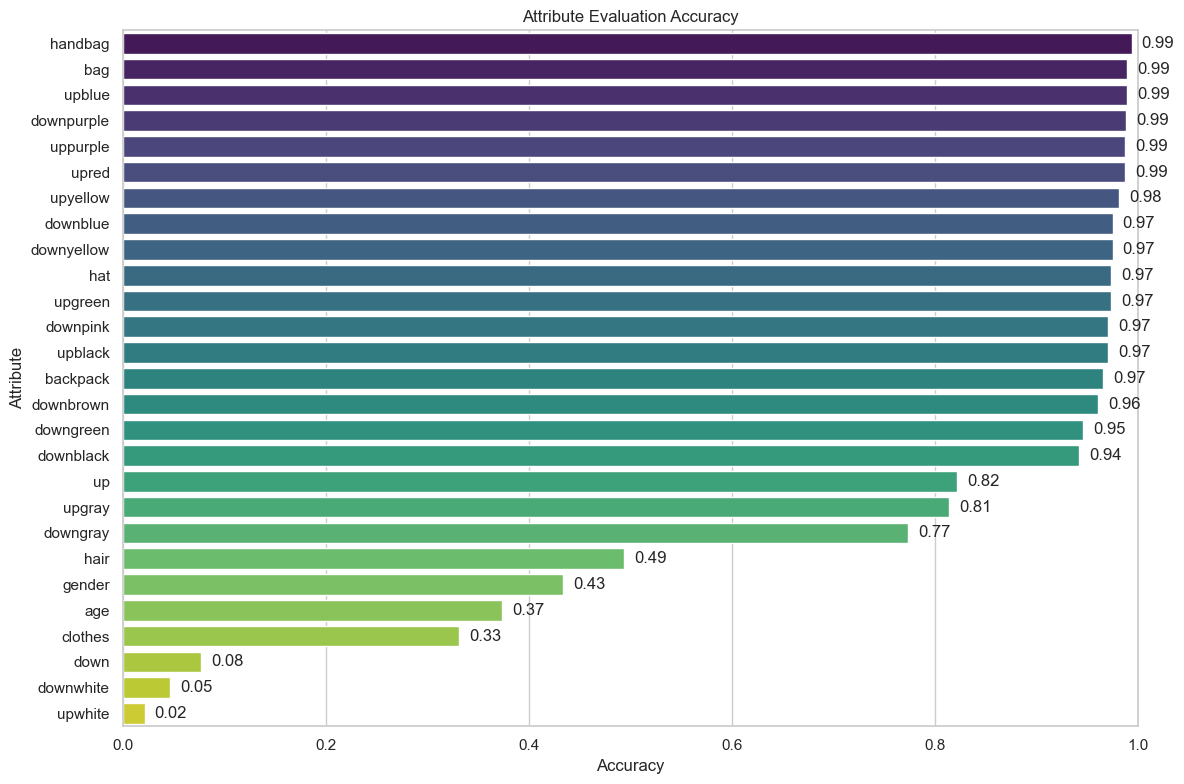

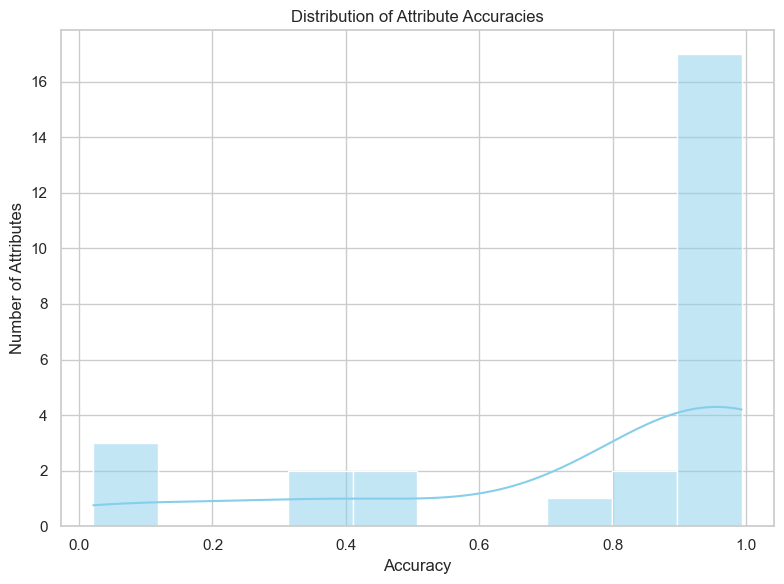

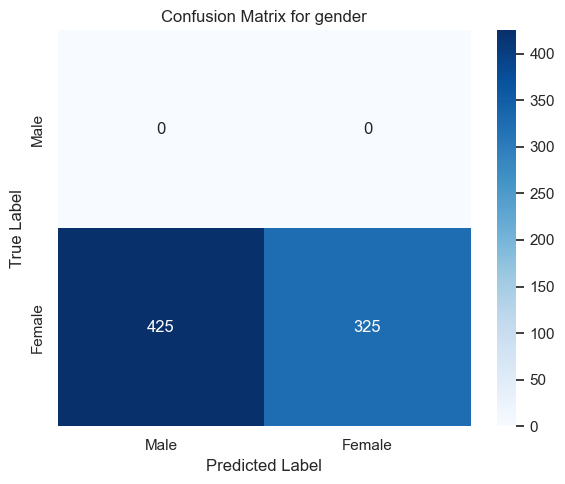

Mean Accuracy across all attributes: 0.77


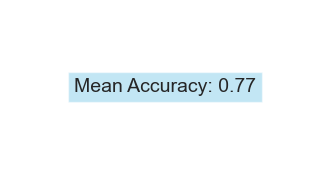

In [89]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load evaluation results
with open('market1501_evaluation.json', 'r') as f:
    final_results = json.load(f)

# Extract data into DataFrame
attributes = final_results['attributes']
data = []

for attr, details in attributes.items():
    data.append({
        'Attribute': attr,
        'Accuracy': details['accuracy'],
        'Total Samples': details['total_samples']
    })

df = pd.DataFrame(data)
df = df.sort_values(by='Accuracy', ascending=False)

# Plot accuracy per attribute
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Attribute', data=df, palette='viridis')
plt.title('Attribute Evaluation Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Attribute')
plt.xlim(0, 1)

for index, value in enumerate(df['Accuracy']):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center')

plt.tight_layout()
plt.show()

# Plot distribution of accuracies
plt.figure(figsize=(8, 6))
sns.histplot(df['Accuracy'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Attribute Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Number of Attributes')
plt.tight_layout()
plt.show()

# Plot confusion matrix for 'gender'
attribute = 'gender'
preds = attributes[attribute]['predictions']
labels = attributes[attribute]['ground_truth']
cm = confusion_matrix(labels, preds)
classes = ['Male', 'Female']  # Adjust based on actual labels

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix for {attribute}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Display mean accuracy
mean_accuracy = final_results['mean_accuracy']
print(f"Mean Accuracy across all attributes: {mean_accuracy:.2f}")

plt.figure(figsize=(4, 2))
plt.text(0.5, 0.5, f"Mean Accuracy: {mean_accuracy:.2f}", 
         horizontalalignment='center', 
         verticalalignment='center', 
         fontsize=14, 
         bbox=dict(facecolor='skyblue', alpha=0.5))
plt.axis('off')
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Example: One-hot encoding for categorical attributes
def encode_attributes(attr_dict):
    encoded_features = {}
    for key, values in attr_dict.items():
        # Reshape for encoder
        values = np.array(values).reshape(-1, 1)
        encoder = OneHotEncoder(sparse=False)
        encoded = encoder.fit_transform(values)
        encoded_features[key] = encoded
    return encoded_features

# Encode train and test attributes
train_encoded = encode_attributes(train_attr_dict)
test_encoded = encode_attributes(test_attr_dict)


In [ ]:
import scipy.io
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from PIL import Image
from aimv2_feature_processor import AIMv2FeatureProcessor
# Assuming AIMv2FeatureProcessor is already defined and imported

def load_attributes(attribute_file):
    mat_data = scipy.io.loadmat(attribute_file)
    market_attributes = mat_data['market_attribute']
    train_attributes = market_attributes['train'][0][0]
    test_attributes = market_attributes['test'][0][0]
    
    def extract_attributes(attr_data):
        attributes = {}
        for key in attr_data.dtype.names:
            attributes[key] = attr_data[key][0]
        return attributes
    
    train_attr_dict = extract_attributes(train_attributes)
    test_attr_dict = extract_attributes(test_attributes)
    return train_attr_dict, test_attr_dict

def encode_attributes(attr_dict):
    # Implement encoding as needed
    # For simplicity, return as-is
    return attr_dict

def extract_identity_features(image_paths, feature_processor):
    identity_features = {}
    for image_path in image_paths:
        basename = os.path.basename(image_path)
        identity = basename.split('_')[0]
        features = feature_processor.process_image_and_text(image=image_path, text_descriptions=None)
        if features and 'image_features' in features:
            image_feat = features['image_features'][0]
            if identity in identity_features:
                identity_features[identity].append(image_feat)
            else:
                identity_features[identity] = [image_feat]
    # Aggregate
    for identity in identity_features:
        identity_features[identity] = np.mean(identity_features[identity], axis=0)
    return identity_features

def evaluate_model(train_features, test_features):
    # Similarity-based retrieval
    train_ids = list(train_features.keys())
    train_matrix = np.vstack([train_features[id] for id in train_ids])
    
    test_ids = list(test_features.keys())
    test_matrix = np.vstack([test_features[id] for id in test_ids])
    
    similarity = cosine_similarity(test_matrix, train_matrix)
    retrieved_indices = np.argmax(similarity, axis=1)
    retrieved_ids = [train_ids[idx] for idx in retrieved_indices]
    
    correct = sum([test_id == retrieved_id for test_id, retrieved_id in zip(test_ids, retrieved_ids)])
    accuracy = correct / len(test_ids)
    print(f"Retrieval Accuracy: {accuracy * 100:.2f}%")
    
    return accuracy

import os

def get_image_paths(image_dir):
    """
    Get all image file paths from a directory.

    Args:
        image_dir (str): Path to the directory containing images.

    Returns:
        list: List of image file paths.
    """
    image_paths = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Add other formats if needed
                image_paths.append(os.path.join(root, file))
    return image_paths

def extract_identity_features(image_paths, feature_processor):
    """
    Extract and aggregate features per identity.

    Args:
        image_paths (list): List of image file paths.
        feature_processor (AIMv2FeatureProcessor): Feature extraction processor.

    Returns:
        dict: A dictionary mapping identities to their aggregated features.
    """
    identity_features = {}
    for image_path in image_paths:
        # Extract identity from image filename, assuming format: {id}_c{camera}_{index}.jpg
        basename = os.path.basename(image_path)
        identity = basename.split('_')[0]
        
        # Extract features using AIMv2
        features = feature_processor.process_image_and_text(image=image_path, text_descriptions=None)
        if features and 'image_features' in features:
            image_feat = features['image_features'][0]  # Assuming batch size of 1
            if identity in identity_features:
                identity_features[identity].append(image_feat)
            else:
                identity_features[identity] = [image_feat]
                
    # Aggregate features per identity (e.g., by averaging)
    for identity in identity_features:
        identity_features[identity] = np.mean(identity_features[identity], axis=0)
    
    return identity_features



def main():
    attribute_file = 'Market-1501_Attribute/market_attribute.mat'
    train_image_dir = './Market-1501/images/bounding_box_train/'
    test_image_dir = './Market-1501/images/bounding_box_test/'
    
    # Load attributes
    train_attr, test_attr = load_attributes(attribute_file)
    
    # Initialize feature processor
    features_json_path = '1501features.json'
    cache_dir = 'face_feature_cache/aimv2/1501'
    feature_processor = AIMv2FeatureProcessor(features_json_path, cache_dir)
    
    # Get image paths
    train_image_paths = get_image_paths(train_image_dir)
    test_image_paths = get_image_paths(test_image_dir)
    
    # Extract features
    train_features = extract_identity_features(train_image_paths, feature_processor)
    test_features = extract_identity_features(test_image_paths, feature_processor)
    
    # Evaluate
    evaluate_model(train_features, test_features)
    
    # Example: Attribute-based classification (Gender)
    train_ids = list(train_features.keys())
    train_matrix = np.array([train_features[id] for id in train_ids])
    train_genders = train_attr['gender'][:len(train_ids)]
    
    test_ids = list(test_features.keys())
    test_matrix = np.array([test_features[id] for id in test_ids])
    test_genders = test_attr['gender'][:len(test_ids)]
    
    # Train classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(train_matrix, train_genders)
    
    # Predict
    predictions = classifier.predict(test_matrix)
    
    # Report
    print("Gender Classification Report:")
    print(classification_report(test_genders, predictions))


if __name__ == "__main__":
    main()


In [ ]:
import torch
print(torch.__version__)

In [ ]:
!pip show torch

In [ ]:
from aimv2_feature_processor import AIMv2FeatureProcessor
# 初始化評估器
evaluator = Market1501Evaluator()

# 載入屬性數據
evaluator.load_attributes('Market-1501_Attribute/market_attribute.mat')

# 使用你的模型進行評估
results = evaluator.evaluate_attributes(
    model=your_model,
    attribute_file=,
    dataset_path='Market-1501-v15.09.15'
)
# 使用你的模型進行評估
results = evaluator.evaluate_attributes(
    model=your_model,
    dataset_path='Market-1501-v15.09.15',
    split='test'
)
# 獲取數據集統計信息
stats = evaluator.get_attribute_statistics()

In [ ]:
import scipy.io

# 加载 .mat 文件
attribute_file = './clean_project/Market-1501_Attribute/market_attribute.mat'
mat_data = scipy.io.loadmat(attribute_file)

# List all keys in the MAT file
print("Keys in the MAT file:", mat_data.keys())
# Access 'market_attribute'
market_attributes = mat_data['market_attribute']

# Check its type and structure
print("Type of market_attribute:", type(market_attributes))
print("Shape of market_attribute:", market_attributes.shape)

# Inspect the fields of the structure (if it is a structured array)
if isinstance(market_attributes, np.ndarray) and market_attributes.dtype.names:
    print("Fields in market_attribute:", market_attributes.dtype.names)
# Extract training and testing attributes
train_attributes = market_attributes['train'][0][0]
test_attributes = market_attributes['test'][0][0]

# Check the fields in train/test
print("Fields in train attributes:", train_attributes.dtype.names)
print("Fields in test attributes:", test_attributes.dtype.names)

In [ ]:
import pandas as pd

# Extract fields from training attributes
train_data = {field: train_attributes[field][0] for field in train_attributes.dtype.names}

# Convert to DataFrame
train_df = pd.DataFrame(train_data)

# Inspect the DataFrame
print(train_df.head())


In [68]:
import numpy as np
from scipy.io import loadmat
import os
from PIL import Image
from typing import Dict, List, Tuple
from collections import defaultdict

import numpy as np
from scipy.io import loadmat
import os
from PIL import Image
from typing import Dict, List, Tuple
from collections import defaultdict

class Market1501Evaluator:
    def __init__(self, aimv2_processor, attribute_file: str, dataset_path: str):
        self.processor = aimv2_processor
        self.attribute_data = loadmat(attribute_file)
        self.dataset_path = dataset_path
        
        # Define attribute label mappings
        self.basic_attributes = {
            'gender': {1: 'male', 2: 'female'},
            'hair': {1: 'short hair', 2: 'long hair'},
            'up': {1: 'long sleeve', 2: 'short sleeve'},
            'down': {1: 'long lower body clothing', 2: 'short'},
            'clothes': {1: 'dress', 2: 'pants'},
            'hat': {1: 'no', 2: 'yes'},
            'backpack': {1: 'no', 2: 'yes'},
            'bag': {1: 'no', 2: 'yes'},
            'handbag': {1: 'no', 2: 'yes'},
            'age': {1: 'young', 2: 'teenager', 3: 'adult', 4: 'old'}
        }
        
        # Color attributes
        self.up_colors = ['black', 'white', 'red', 'purple', 'yellow', 'gray', 'blue', 'green']
        self.down_colors = ['black', 'white', 'pink', 'purple', 'yellow', 'gray', 'blue', 'green', 'brown']
        
        self.up_color_fields = ['upblack', 'upwhite', 'upred', 'uppurple', 'upyellow', 'upgray', 'upblue', 'upgreen']
        self.down_color_fields = ['downblack', 'downwhite', 'downpink', 'downpurple', 'downyellow', 
                                'downgray', 'downblue', 'downgreen', 'downbrown']
                                
    def _get_split_data(self, split):
        """Helper method to get split data"""
        return self.attribute_data['market_attribute'][split][0, 0]

    def get_attribute_statistics(self, split='test'):
        split_data = self._get_split_data(split)
        stats = {
            'basic_attributes': {},
            'upper_colors': {},
            'lower_colors': {},
            'total_samples': split_data[split_data.dtype.names[0]][0, 0].shape[0]
        }

        # Process basic attributes
        for attr, label_map in self.basic_attributes.items():
            if attr in split_data.dtype.names:
                values = split_data[attr][0, 0]
                unique, counts = np.unique(values, return_counts=True)
                stats['basic_attributes'][attr] = {
                    'distribution': {label_map[int(val)]: int(count) 
                                   for val, count in zip(unique, counts)},
                    'total': len(values)
                }

        # Process upper body colors
        for field, color in zip(self.up_color_fields, self.up_colors):
            if field in split_data.dtype.names:
                values = split_data[field][0, 0]
                stats['upper_colors'][color] = int(np.sum(values == 2))

        # Process lower body colors
        for field, color in zip(self.down_color_fields, self.down_colors):
            if field in split_data.dtype.names:
                values = split_data[field][0, 0]
                stats['lower_colors'][color] = int(np.sum(values == 2))

        return stats

    def print_statistics(self, split='test'):
        stats = self.get_attribute_statistics(split)
        
        print(f"\n=== Market-1501 {split} set Statistics ===")
        print(f"Total samples: {stats['total_samples']}\n")
        
        print("=== Basic Attributes ===")
        for attr, data in stats['basic_attributes'].items():
            print(f"\n{attr.upper()}:")
            total = data['total']
            for label, count in data['distribution'].items():
                percentage = (count / total) * 100
                print(f"  {label}: {count} ({percentage:.1f}%)")
        
        print("\n=== Upper Body Colors ===")
        total_upper = sum(stats['upper_colors'].values())
        for color, count in stats['upper_colors'].items():
            percentage = (count / total_upper) * 100
            print(f"  {color}: {count} ({percentage:.1f}%)")
            
        print("\n=== Lower Body Colors ===")
        total_lower = sum(stats['lower_colors'].values())
        for color, count in stats['lower_colors'].items():
            percentage = (count / total_lower) * 100
            print(f"  {color}: {count} ({percentage:.1f}%)")

    def _create_attribute_descriptions(self, person_data):
        descriptions = []
        try:
            # Process basic attributes
            for attr, values in self.basic_attributes.items():
                if attr in person_data:
                    value = int(person_data[attr])
                    if attr in ['hat', 'backpack', 'bag', 'handbag']:
                        if value == 2:  # yes
                            descriptions.append(f"wearing {attr}" if attr == 'hat' else f"carrying {attr}")
                    else:
                        if value in values:
                            descriptions.append(f"person with {values[value]}")
            
            # Process upper body colors
            for field, color in zip(self.up_color_fields, self.up_colors):
                if field in person_data and int(person_data[field]) == 2:
                    descriptions.append(f"wearing {color} upper clothing")
                    break
                    
            # Process lower body colors
            for field, color in zip(self.down_color_fields, self.down_colors):
                if field in person_data and int(person_data[field]) == 2:
                    descriptions.append(f"wearing {color} lower clothing")
                    break
        except Exception as e:
            print(f"Error creating descriptions: {e}")
            descriptions = ["person"]
            
        if not descriptions:
            descriptions.append("person")
        return descriptions

    def print_example_descriptions(self, num_examples=5, split='test'):
        split_data = self._get_split_data(split)
        total_samples = split_data[split_data.dtype.names[0]][0, 0].shape[0]
        
        print(f"\n=== Example Descriptions ({split} set) ===")
        for i in range(min(num_examples, total_samples)):
            person_data = {}
            for field in split_data.dtype.names:
                if field != 'image_index':
                    value = split_data[field][0, 0][i]
                    if isinstance(value, (np.generic, np.ndarray)):
                        person_data[field] = value.item()
                    else:
                        person_data[field] = value
            
            print(f"\nSample {i+1}:")
            print("Raw attributes:", {k: str(v) for k, v in person_data.items()})
            descriptions = self._create_attribute_descriptions(person_data)
            print("Generated descriptions:", descriptions)
    def print_statistics(self, split='test'):
        """
        打印統計資訊
        """
        stats = self.get_attribute_statistics(split)
        
        print(f"\n=== Market-1501 {split} set Statistics ===")
        print(f"Total samples: {stats['total_samples']}\n")
        
        print("=== Basic Attributes ===")
        for attr, data in stats['basic_attributes'].items():
            print(f"\n{attr.upper()}:")
            total = data['total']
            for label, count in data['distribution'].items():
                percentage = (count / total) * 100
                print(f"  {label}: {count} ({percentage:.1f}%)")
        
        print("\n=== Upper Body Colors ===")
        total_upper = sum(stats['upper_colors'].values())
        for color, count in stats['upper_colors'].items():
            percentage = (count / total_upper) * 100
            print(f"  {color}: {count} ({percentage:.1f}%)")
            
        print("\n=== Lower Body Colors ===")
        total_lower = sum(stats['lower_colors'].values())
        for color, count in stats['lower_colors'].items():
            percentage = (count / total_lower) * 100
            print(f"  {color}: {count} ({percentage:.1f}%)")

    def print_example_descriptions(self, num_examples=5, split='test'):
        """
        打印一些示例的屬性描述
        """
        split_data = self.attribute_data['market_attribute'][split][0, 0]
        total_samples = split_data[split_data.dtype.names[0]][0, 0].shape[0]
        
        print(f"\n=== Example Descriptions ({split} set) ===")
        for i in range(min(num_examples, total_samples)):
            person_data = {}
            for field in split_data.dtype.names:
                if field != 'image_index':
                    value = split_data[field][0, 0][i]
                    if isinstance(value, np.generic):
                        person_data[field] = value.item()
                    else:
                        person_data[field] = value
                        
            descriptions = self._create_attribute_descriptions(person_data)
            print(f"\nSample {i+1}:")
            print("Raw attributes:", person_data)
            print("Generated descriptions:", descriptions)

    def evaluate_attributes(self, split: str = 'test') -> Dict:
        """
        評估屬性預測性能
        """
        if split not in ['train', 'test']:
            raise ValueError("split must be either 'train' or 'test'")
            
        # 首先打印數據集統計信息
        self.print_statistics(split)
        
        # 打印一些示例描述
        self.print_example_descriptions(num_examples=3, split=split)
        
        # 獲取分割數據
        split_data = self.attribute_data['market_attribute'][split][0, 0]
        max_id = split_data[split_data.dtype.names[0]][0, 0].shape[0]
            
        # 首先獲取分割數據
        split_data = self.attribute_data['market_attribute'][split][0, 0]
        max_id = split_data[split_data.dtype.names[0]][0, 0].shape[0]
            
        results = {
            'accuracy_per_attribute': {},
            'overall_accuracy': 0.0,
            'processed_images': 0,
            'attribute_metrics': {},
            'statistics': {
                'total_images': 0,
                'processed_images': 0,
                'skipped_images': {
                    'invalid_id': 0,
                    'out_of_range': 0,
                    'processing_error': 0
                }
            }
        }
        
        print(f"\nProcessing {split} split:")
        print(f"Maximum valid ID: {max_id}")
        
        # Process each image
        image_dir = os.path.join(self.dataset_path, 'bounding_box_train' if split == 'train' else 'bounding_box_test')
        
        # Map split to correct directory
        split_dir = 'bounding_box_train' if split == 'train' else 'bounding_box_test'
        image_dir = os.path.join(self.dataset_path, split_dir)
        for img_name in os.listdir(image_dir):
            if not img_name.endswith('.jpg'):
                continue
                
            try:
                results['statistics']['total_images'] += 1
                
                try:
                    # Extract person ID from image name
                    person_id = int(img_name.split('_')[0])
                    
                    # Skip invalid IDs (-1 and other special cases)
                    if person_id <= 0:
                        results['statistics']['skipped_images']['invalid_id'] += 1
                        continue
                        
                    image_path = os.path.join(image_dir, img_name)
                    
                    # 檢查 person_id 是否在有效範圍內
                    max_id = split_data[split_data.dtype.names[0]][0, 0].shape[0]
                    if person_id > max_id:
                        results['statistics']['skipped_images']['out_of_range'] += 1
                        continue
                        
                    # Convert numpy types to Python native types
                    person_data = {}
                    for field in split_data.dtype.names:
                        if field != 'image_index':
                            value = split_data[field][0, 0][person_id-1]
                            if isinstance(value, np.ndarray):
                                person_data[field] = value.item() if value.size == 1 else value.tolist()
                            elif isinstance(value, np.generic):
                                person_data[field] = value.item()
                            else:
                                person_data[field] = value
                                
                    # Debug output for first few images
                    if results['statistics']['total_images'] < 5:
                        print(f"\nProcessing image {img_name}")
                        print(f"Person data types after conversion:")
                            
                    # Generate descriptions
                    descriptions = self._create_attribute_descriptions(person_data)
                    
                    if len(descriptions) == 0:
                        print(f"Warning: No descriptions generated for image {img_name}")
                        print(f"Person data: {person_data}")
                        results['statistics']['skipped_images']['processing_error'] += 1
                        continue
                    
                    # Get features using AIMv2
                    features = self.processor.process_image_and_text(
                        image=image_path,
                        text_descriptions=descriptions
                    )
                    
                    if features is None:
                        results['statistics']['skipped_images']['processing_error'] += 1
                        continue
                        
                    # Calculate similarities
                    image_features = features['image_features']
                    text_features = features['text_features']
                    similarities = np.dot(image_features, text_features.T)[0]
                    
                    # Update metrics
                    for idx, description in enumerate(descriptions):
                        # Extract attribute type from description
                        attr_type = description.split()[1] if len(description.split()) > 1 else description.split()[0]
                        
                        if attr_type not in results['attribute_metrics']:
                            results['attribute_metrics'][attr_type] = {
                                'correct': 0,
                                'total': 0,
                                'similarities': []
                            }
                        
                        # Consider prediction correct if similarity is above threshold
                        is_correct = similarities[idx] > 0.5
                        results['attribute_metrics'][attr_type]['correct'] += int(is_correct)
                        results['attribute_metrics'][attr_type]['total'] += 1
                        results['attribute_metrics'][attr_type]['similarities'].append(float(similarities[idx]))
                    
                    results['statistics']['processed_images'] += 1
                    
                except Exception as e:
                    print(f"Error processing image {img_name}: {e}")
                    results['statistics']['skipped_images']['processing_error'] += 1
                    continue
                        
                    # 確保 person_id 在有效範圍內 (1 到 750/751)
                    if not (1 <= person_id <= max_id):
                        continue
                    
                # Get ground truth attributes
                person_data = {}
                try:
                    for field in split_data.dtype.names:
                        if field != 'image_index':
                            person_data[field] = split_data[field][0, 0][person_id-1]
                except IndexError:
                    print(f"Error accessing attributes for image {img_name}: index {person_id-1} is invalid")
                    continue
                
                # Generate descriptions
                descriptions = self._create_attribute_descriptions(person_data)
                
                # Get features using AIMv2
                features = self.processor.process_image_and_text(
                    image=image_path,
                    text_descriptions=descriptions
                )
                
                if features is None:
                    continue
                
                # Calculate similarities
                image_features = features['image_features']
                text_features = features['text_features']
                similarities = np.dot(image_features, text_features.T)[0]
                
                # Update metrics
                for idx, description in enumerate(descriptions):
                    # Extract attribute type from description
                    attr_type = description.split()[1] if len(description.split()) > 1 else description.split()[0]
                    
                    if attr_type not in results['attribute_metrics']:
                        results['attribute_metrics'][attr_type] = {
                            'correct': 0,
                            'total': 0,
                            'similarities': []
                        }
                    
                    # Consider prediction correct if similarity is above threshold
                    is_correct = similarities[idx] > 0.5
                    results['attribute_metrics'][attr_type]['correct'] += int(is_correct)
                    results['attribute_metrics'][attr_type]['total'] += 1
                    results['attribute_metrics'][attr_type]['similarities'].append(float(similarities[idx]))
                
                results['processed_images'] += 1
                
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
        
        # Calculate final metrics
        for attr_type, metrics in results['attribute_metrics'].items():
            accuracy = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
            avg_similarity = np.mean(metrics['similarities'])
            
            results['accuracy_per_attribute'][attr_type] = {
                'accuracy': accuracy,
                'average_similarity': avg_similarity,
                'total_samples': metrics['total']
            }
        
        # Calculate overall accuracy
        accuracies = [m['accuracy'] for m in results['accuracy_per_attribute'].values()]
        results['overall_accuracy'] = np.mean(accuracies)
        
        return results

    def get_attribute_statistics(self) -> Dict:
        """
        Get distribution statistics for all attributes in the dataset
        """
        stats = {
            'train': {},
            'test': {}
        }
        
        for split in ['train', 'test']:
            split_data = self.attribute_data['market_attribute'][split][0, 0]
            
            # Basic attributes
            for attr, mapping in self.basic_attributes.items():
                if attr in split_data.dtype.names:
                    values, counts = np.unique(split_data[attr][0, 0], return_counts=True)
                    stats[split][attr] = {
                        mapping[int(val)]: int(count) 
                        for val, count in zip(values, counts)
                    }
            
            # Upper body colors
            for field, color in zip(self.up_color_fields, self.up_colors):
                if field in split_data.dtype.names:
                    values, counts = np.unique(split_data[field][0, 0], return_counts=True)
                    stats[split][f'upper_{color}'] = {
                        'no': int(counts[0]) if len(counts) > 0 else 0,
                        'yes': int(counts[1]) if len(counts) > 1 else 0
                    }
            
            # Lower body colors
            for field, color in zip(self.down_color_fields, self.down_colors):
                if field in split_data.dtype.names:
                    values, counts = np.unique(split_data[field][0, 0], return_counts=True)
                    stats[split][f'lower_{color}'] = {
                        'no': int(counts[0]) if len(counts) > 0 else 0,
                        'yes': int(counts[1]) if len(counts) > 1 else 0
                    }
        
        return stats

In [ ]:
from aimv2_feature_processor import AIMv2FeatureProcessor

features_json_path = 'features.json'
processor = AIMv2FeatureProcessor(features_json_path)


# 初始化評估器
evaluator = Market1501Evaluator(
    aimv2_processor=processor,
    attribute_file='Market-1501_Attribute/market_attribute.mat',
    dataset_path='Market-1501-v15.09.15'
)

evaluator.print_statistics('test')
evaluator.print_example_descriptions(num_examples=5, split='test')


# # 載入屬性數據
# evaluator.load_attributes('Market-1501_Attribute/market_attribute.mat')

# # 使用你的模型進行評估
# results = evaluator.evaluate_attributes(
#     model=your_model,
#     attribute_file=,
#     dataset_path='Market-1501-v15.09.15'
# )



In [ ]:
results

In [ ]:
results